In [5]:
import pandas as pd
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,  roc_auc_score
import gc
import category_encoders as ce
from sklearn.model_selection import *
# plt.style.use('seaborn-colorblind')
# %matplotlib inline
#from feature_cleaning import rare_values as ra
from feature_selection.feature_utils import *
from feature_selection.feature_shuffle import *
from feature_cleaning.collinear import *
from joblib import Parallel,delayed


## 读取原始数据


In [6]:
def lgb_model(params=None,cv=KFold(5),X=None,y=None,early_stopping_rounds=200,cols=None,categorical_feature=None,group_feature=None):

    #folds = StratifiedKFold(n_splits=NFOLDS)
    folds =cv
    if cols==None:
        columns = list(X.columns)
    else:
        columns=cols
    if group_feature:
        columns.remove(group_feature)
        splits = folds.split(X[columns], y,groups=X[group_feature])
    else:
        splits = folds.split(X[columns], y)
    y_oof = np.zeros(X.shape[0])
    score = 0


    clfs=[]
    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]


        clf = lgb.LGBMClassifier(**params)
        if categorical_feature:
            clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_valid,y_valid)], \
                     eval_metric='auc', verbose=100, early_stopping_rounds=early_stopping_rounds,categorical_feature=categorical_feature)
        else:
            clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_valid,y_valid)], \
                     eval_metric='auc', verbose=100, early_stopping_rounds=early_stopping_rounds)

        y_pred_valid = clf.predict_proba(X_valid)[:,1]
        y_oof[valid_index] = y_pred_valid
        print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")

        score += roc_auc_score(y_valid, y_pred_valid) / 6

        del X_train, X_valid, y_train, y_valid
        gc.collect()
        clfs.append(clf)

    print(f"\nMean AUC = {score}")
    print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")
    return clfs

In [7]:
import gc
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from feature_cleaning.collinear import *
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold,TimeSeriesSplit
from performance_optimizing import performance_optimizing as po
import os
import random
from feature_selection.feature_utils import get_imp
from feature_engineering.encoding import *
### 注意一定要提前控制随机性问题！！
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(123)

str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: 
    dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'
    
drop_C=['C2', 'C4', 'C6', 'C8', 'C10', 'C11', 'C14']

cat=pd.read_csv('cat.csv')
cat=cat.cat.values.tolist()
params = {'num_leaves': 491,
          'colsample_bytree': 0.75,
          'subsample': 0.75,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.45,
          'reg_lambda': 0.65,
          'random_state': 47,
          'n_jobs':-1,
          'n_estimators':10000,
         }
# LOAD TRAIN
path=r'F:\python代码\kaggle_ieee'+'\\'
X_train = pd.read_csv(path+'train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv(path+'train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv(path+'test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv(path+'test_identity.csv',index_col='TransactionID', dtype=dtypes)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)
X=X_train
y=y_train
del X_train,y_train
gc.collect()
X.drop(drop_C,axis=1,inplace=True)
X_test.drop(drop_C,axis=1,inplace=True)

Train shape (590540, 213) test shape (506691, 213)


In [8]:
X.shape

(590540, 206)

In [9]:
for col in cat:
    encode_LE(col,X,X_test)

ProductCD , card1 , card2 , card3 , card4 , card5 , card6 , addr1 , addr2 , M1 , M2 , M3 , M4 , M5 , M6 , M7 , M8 , M9 , id_12 , id_13 , id_14 , id_15 , id_16 , id_17 , id_18 , id_19 , id_20 , id_21 , id_22 , id_23 , id_24 , id_25 , id_26 , id_27 , id_28 , id_29 , id_30 , id_31 , id_32 , id_33 , id_34 , id_35 , id_36 , id_37 , id_38 , DeviceType , DeviceInfo , P_emaildomain , R_emaildomain , 

## 从类别开始，首先，重要类别的编码

In [10]:
imp_cat=['card1','card2','R_emaildomain','ProductCD','addr1','M4','M6']
encode_FE(X,X_test,imp_cat)

card1_FE , card2_FE , R_emaildomain_FE , ProductCD_FE , addr1_FE , M4_FE , M6_FE , 

In [6]:
X[['card1_FE','card2_FE','R_emaildomain_FE' ,'ProductCD_FE','addr1_FE' ,'M4_FE','M6_FE']].rank().corr()

,card1_FE,card2_FE,R_emaildomain_FE,ProductCD_FE,addr1_FE,M4_FE,M6_FE
card1_FE,1.000000,0.326302,0.000908,0.017008,0.093084,0.042970,0.033158
card2_FE,0.326302,1.000000,-0.049606,0.032494,0.133270,-0.038416,0.034604
R_emaildomain_FE,0.000908,-0.049606,1.000000,-0.901822,-0.339243,-0.120519,-0.715509
ProductCD_FE,0.017008,0.032494,-0.901822,1.000000,0.258727,0.227700,0.759988
addr1_FE,0.093084,0.133270,-0.339243,0.258727,1.000000,-0.088712,0.256749
M4_FE,0.042970,-0.038416,-0.120519,0.227700,-0.088712,1.000000,0.165671
M6_FE,0.033158,0.034604,-0.715509,0.759988,0.256749,0.165671,1.000000


In [117]:
X[imp_cat+['card1_FE','card2_FE','R_emaildomain_FE' ,'ProductCD_FE','addr1_FE' ,'M4_FE','M6_FE']].rank().corr() ##与原始特征也要比较以下

,card1,card2,R_emaildomain,ProductCD,addr1,M4,M6,card1_FE,card2_FE,R_emaildomain_FE,ProductCD_FE,addr1_FE,M4_FE,M6_FE
card1,1.000000,0.008141,-0.000384,0.001496,0.012644,0.003859,0.002496,0.068657,0.058326,-0.002829,0.003697,0.038665,-0.000802,0.002424
card2,0.008141,1.000000,0.109247,-0.115572,-0.005915,0.003751,-0.077957,-0.131778,0.039018,0.108850,-0.120664,-0.041564,-0.025547,-0.121550
R_emaildomain,-0.000384,0.109247,1.000000,-0.923620,-0.315789,0.136781,-0.715509,0.004014,-0.052065,0.972614,-0.901100,-0.339668,-0.118429,-0.715509
ProductCD,0.001496,-0.115572,-0.923620,1.000000,0.362563,-0.157605,0.759988,-0.008026,0.054464,-0.923579,0.954254,0.389865,0.117514,0.759988
addr1,0.012644,-0.005915,-0.315789,0.362563,1.000000,-0.285742,0.226515,-0.045504,0.030898,-0.313666,0.232855,0.240078,-0.110385,0.232587
M4,0.003859,0.003751,0.136781,-0.157605,-0.285742,1.000000,-0.065267,0.059024,-0.067620,0.133273,0.019921,-0.278427,0.766393,-0.032514
M6,0.002496,-0.077957,-0.715509,0.759988,0.226515,-0.065267,1.000000,-0.001368,0.042063,-0.715509,0.759988,0.277385,0.117235,0.388465
card1_FE,0.068657,-0.131778,0.004014,-0.008026,-0.045504,0.059024,-0.001368,1.000000,0.326302,0.000908,0.017008,0.093084,0.042970,0.033158
card2_FE,0.058326,0.039018,-0.052065,0.054464,0.030898,-0.067620,0.042063,0.326302,1.000000,-0.049606,0.032494,0.133270,-0.038416,0.034604
R_emaildomain_FE,-0.002829,0.108850,0.972614,-0.923579,-0.313666,0.133273,-0.715509,0.000908,-0.049606,1.000000,-0.901822,-0.339243,-0.120519,-0.715509


In [26]:
result=kris_feature_select(cols=['card1_FE','card2_FE','R_emaildomain_FE' ,'ProductCD_FE','addr1_FE' ,'M4_FE','M6_FE'], \
                           X=X,y=y,cv=KFold(5),params=None)
for func in [np.mean,np.min,np.max]:
    print(str(np.mean)+':')
    print(result.groupby('flag')['train_auc','valid_auc','auc_delta'].apply(func))
    print('====================================================================')

<function mean at 0x000002635FC82268>:
      train_auc  valid_auc  auc_delta
flag                                 
0       0.71170    0.68096    0.03074
1       0.73544    0.71450    0.02094
2       0.68490    0.68262    0.00228
3       0.67936    0.68022   -0.00086
4       0.68992    0.66968    0.02024
5       0.67018    0.66996    0.00022
6       0.66404    0.66472   -0.00068
<function mean at 0x000002635FC82268>:
      train_auc  valid_auc  auc_delta
flag                                 
0        0.7032     0.6451    -0.0066
1        0.7274     0.6815    -0.0135
2        0.6783     0.6283    -0.0283
3        0.6739     0.6272    -0.0259
4        0.6839     0.6452    -0.0114
5        0.6603     0.6336    -0.0484
6        0.6563     0.5721    -0.0386
<function mean at 0x000002635FC82268>:
      train_auc  valid_auc  auc_delta
flag                                 
0        0.7184     0.7098     0.0733
1        0.7412     0.7409     0.0597
2        0.6985     0.7066     0.0702
3        

In [25]:
cols=list(X.columns)
cols.remove('TransactionDT')
clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=200,cols=cols,categorical_feature=None,group_feature=None)


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.948721	valid_1's auc: 0.884388
[200]	training's auc: 0.966251	valid_1's auc: 0.896033
[300]	training's auc: 0.979666	valid_1's auc: 0.903709
[400]	training's auc: 0.98741	valid_1's auc: 0.909168
[500]	training's auc: 0.992144	valid_1's auc: 0.912527
[600]	training's auc: 0.994977	valid_1's auc: 0.914795
[700]	training's auc: 0.996705	valid_1's auc: 0.916551
[800]	training's auc: 0.997791	valid_1's auc: 0.917607
[900]	training's auc: 0.998428	valid_1's auc: 0.91801
[1000]	training's auc: 0.998848	valid_1's auc: 0.918152
[1100]	training's auc: 0.999184	valid_1's auc: 0.918114
[1200]	training's auc: 0.999414	valid_1's auc: 0.918101
[1300]	training's auc: 0.999568	valid_1's auc: 0.917919
Early stopping, best iteration is:
[1115]	training's auc: 0.999226	valid_1's auc: 0.918226
Fold 1 | AUC: 0.9182260600925516
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.948208	vali

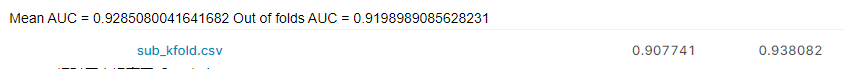

线下提高了千6左右，线上成绩如下：

线上涨了千4左右，b榜涨了千7。。。，仅仅是简单的frequent编码而已就起到如此巨大的作用了

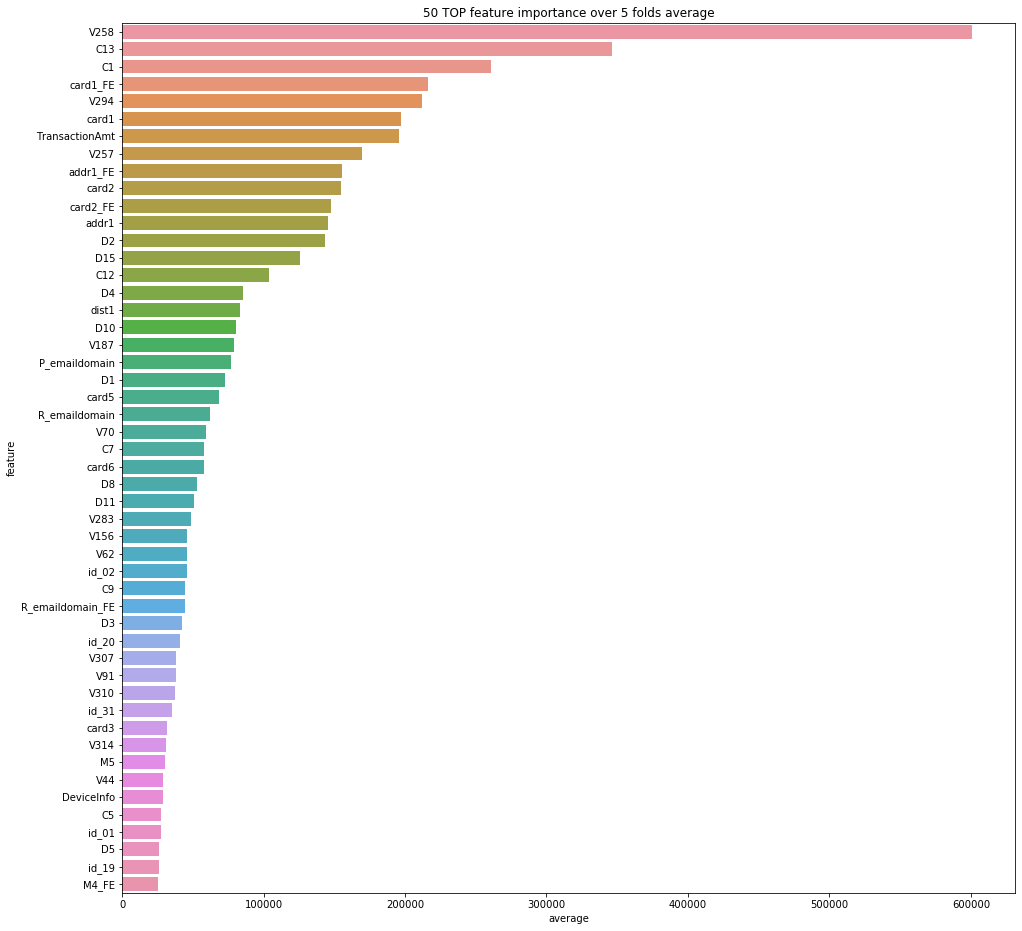

In [29]:
feature_importances=get_imp(clfs,imp_type='gain',feature_names=cols)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(5));

In [28]:
#X_test[cat]=X_test[cat].astype(np.int64)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
sub=pd.read_csv('sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv('.\submit\create_cat_fe_encoding.csv',index=False)

todo: 尝试下target encoding,woe encoding等不同的编码方式

## 然后是重要类别的两两合并，以及三个三个合并，一般最多就做到3个，再多的话太多了,内存撑不住。。。

In [11]:
imp_cat=['card1', 'card2', 'R_emaildomain', 'ProductCD', 'addr1', 'M4', 'M6']

In [12]:
from itertools import combinations
combs2=list(combinations(imp_cat,2))
combs3=list(combinations(imp_cat,3))

In [13]:
for cross in combs2:
    encode_CB2(cross[0],cross[1],X,X_test)
for cross in combs3:
    encode_CB3(cross[0],cross[1],cross[2],X,X_test)    

card1_card2 , card1_R_emaildomain , card1_ProductCD , card1_addr1 , card1_M4 , card1_M6 , card2_R_emaildomain , card2_ProductCD , card2_addr1 , card2_M4 , card2_M6 , R_emaildomain_ProductCD , R_emaildomain_addr1 , R_emaildomain_M4 , R_emaildomain_M6 , ProductCD_addr1 , ProductCD_M4 , ProductCD_M6 , addr1_M4 , addr1_M6 , M4_M6 , card1_card2_R_emaildomain , card1_card2_ProductCD , card1_card2_addr1 , card1_card2_M4 , card1_card2_M6 , card1_R_emaildomain_ProductCD , card1_R_emaildomain_addr1 , card1_R_emaildomain_M4 , card1_R_emaildomain_M6 , card1_ProductCD_addr1 , card1_ProductCD_M4 , card1_ProductCD_M6 , card1_addr1_M4 , card1_addr1_M6 , card1_M4_M6 , card2_R_emaildomain_ProductCD , card2_R_emaildomain_addr1 , card2_R_emaildomain_M4 , card2_R_emaildomain_M6 , card2_ProductCD_addr1 , card2_ProductCD_M4 , card2_ProductCD_M6 , card2_addr1_M4 , card2_addr1_M6 , card2_M4_M6 , R_emaildomain_ProductCD_addr1 , R_emaildomain_ProductCD_M4 , R_emaildomain_ProductCD_M6 , R_emaildomain_addr1_M4 , R

In [14]:
cross_cat=['card1_card2' , 'card1_R_emaildomain' , 'card1_ProductCD' , 'card1_addr1' , 'card1_M4' , 'card1_M6' ,  \
'card2_R_emaildomain' , 'card2_ProductCD' , 'card2_addr1' , 'card2_M4' , 'card2_M6' , 'R_emaildomain_ProductCD' , \
'R_emaildomain_addr1' , 'R_emaildomain_M4' , 'R_emaildomain_M6' , 'ProductCD_addr1' , 'ProductCD_M4' , 'ProductCD_M6' ,  \
'addr1_M4' , 'addr1_M6' , 'M4_M6' , 'card1_card2_R_emaildomain' , 'card1_card2_ProductCD' , 'card1_card2_addr1' , \
'card1_card2_M4' , 'card1_card2_M6' , 'card1_R_emaildomain_ProductCD' , 'card1_R_emaildomain_addr1' , \
'card1_R_emaildomain_M4' , 'card1_R_emaildomain_M6' , 'card1_ProductCD_addr1' , 'card1_ProductCD_M4' , \
'card1_ProductCD_M6' , 'card1_addr1_M4' , 'card1_addr1_M6' , 'card1_M4_M6' , 'card2_R_emaildomain_ProductCD' , \
'card2_R_emaildomain_addr1' , 'card2_R_emaildomain_M4' , 'card2_R_emaildomain_M6' , 'card2_ProductCD_addr1' ,  \
'card2_ProductCD_M4' , 'card2_ProductCD_M6' , 'card2_addr1_M4' , 'card2_addr1_M6' , 'card2_M4_M6' ,  \
'R_emaildomain_ProductCD_addr1' , 'R_emaildomain_ProductCD_M4' , 'R_emaildomain_ProductCD_M6' ,  \
'R_emaildomain_addr1_M4' , 'R_emaildomain_addr1_M6' , 'R_emaildomain_M4_M6' , 'ProductCD_addr1_M4' , \
'ProductCD_addr1_M6' , 'ProductCD_M4_M6' , 'addr1_M4_M6'] 

In [15]:
total_cat=imp_cat+cross_cat
corr_spearman=X[total_cat].rank().corr()
corr_pearson=X[total_cat].corr()

In [19]:
models=[]
for thereshold in [0.79999,0.899999,0.989999]:
    _,drops_spearman=identify_collinear(corr_spearman,thereshold,X)
    _,drops_pearson=identify_collinear(corr_pearson,thereshold,X)
    drops=list(set(drops_spearman+drops_pearson))
    cols=list(X.columns)
    cols.remove('TransactionDT')
    for col in drops:
        cols.remove(col)
    clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=200,cols=cols,categorical_feature=None,group_feature=None)
    y_pred=np.zeros(X_test.shape[0])
    for clf in clfs:
        y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
    sub=pd.read_csv('sample_submission.csv')
    sub['isFraud']=y_pred
    sub.to_csv('.\submit\create_cat_fe_encoding_cross_cat_2_3_'+str(thereshold)+'.csv',index=False)
    models.append(clfs)
    del cols,clfs,y_pred,sub
    gc.collect()

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.951487	valid_1's auc: 0.886372
[200]	training's auc: 0.968363	valid_1's auc: 0.897479
[300]	training's auc: 0.981375	valid_1's auc: 0.90583
[400]	training's auc: 0.988694	valid_1's auc: 0.911713
[500]	training's auc: 0.99299	valid_1's auc: 0.915205
[600]	training's auc: 0.995653	valid_1's auc: 0.917135
[700]	training's auc: 0.997294	valid_1's auc: 0.91833
[800]	training's auc: 0.998254	valid_1's auc: 0.919067
[900]	training's auc: 0.998794	valid_1's auc: 0.919398
[1000]	training's auc: 0.999152	valid_1's auc: 0.919399
[1100]	training's auc: 0.999407	valid_1's auc: 0.919462
Early stopping, best iteration is:
[922]	training's auc: 0.998905	valid_1's auc: 0.919561
Fold 1 | AUC: 0.9195612640472638
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.950727	valid_1's auc: 0.908837
[200]	training's auc: 0.967413	valid_1's auc: 0.918301
[300]	training's auc: 0.980877	valid_1'

[1100]	training's auc: 0.999398	valid_1's auc: 0.918441
Early stopping, best iteration is:
[916]	training's auc: 0.998883	valid_1's auc: 0.918751
Fold 1 | AUC: 0.9187506882565812
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.951028	valid_1's auc: 0.907336
[200]	training's auc: 0.967645	valid_1's auc: 0.917829
[300]	training's auc: 0.981308	valid_1's auc: 0.926032
[400]	training's auc: 0.989088	valid_1's auc: 0.932101
[500]	training's auc: 0.993573	valid_1's auc: 0.935469
[600]	training's auc: 0.996266	valid_1's auc: 0.937132
[700]	training's auc: 0.997769	valid_1's auc: 0.938068
[800]	training's auc: 0.998612	valid_1's auc: 0.938584
[900]	training's auc: 0.999094	valid_1's auc: 0.938837
[1000]	training's auc: 0.999386	valid_1's auc: 0.938831
Early stopping, best iteration is:
[895]	training's auc: 0.999074	valid_1's auc: 0.938898
Fold 2 | AUC: 0.9388984933234226
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0

Mean AUC = 0.935386894759644   0.7999
Out of folds AUC = 0.9357655285567081   


Mean AUC = 0.9357855516382607     0.8999
Out of folds AUC = 0.936240941281439  
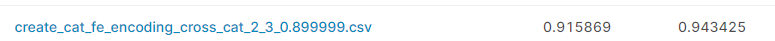

Mean AUC = 0.9355801725689301    0.98999
Out of folds AUC = 0.9362756461827507

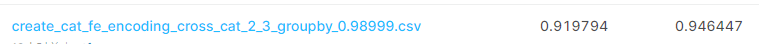

Mean AUC = 0.935734150691389
Out of folds AUC = 0.9351m013612287349   1.000
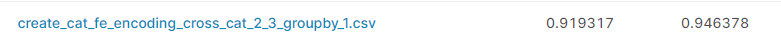

线上差距比较大。。。0.98999的效果最好，居然提高了千3，相当之高了。。。所以我们此时选择a榜结果作为最终结果

In [20]:
cols=list(X.columns)
cols.remove('TransactionDT')
clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=200,cols=cols,categorical_feature=None,group_feature=None)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
sub=pd.read_csv('sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv('.\submit\create_cat_fe_encoding_cross_cat_2_3_'+str(1.000)+'.csv',index=False)
models.append(clfs)
del cols,clfs,y_pred,sub
gc.collect()

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.952716	valid_1's auc: 0.887067
[200]	training's auc: 0.968703	valid_1's auc: 0.898302
[300]	training's auc: 0.982152	valid_1's auc: 0.906469
[400]	training's auc: 0.989164	valid_1's auc: 0.911722
[500]	training's auc: 0.993374	valid_1's auc: 0.914924
[600]	training's auc: 0.995975	valid_1's auc: 0.916709
[700]	training's auc: 0.997509	valid_1's auc: 0.917794
[800]	training's auc: 0.998408	valid_1's auc: 0.918536
[900]	training's auc: 0.998951	valid_1's auc: 0.918719
[1000]	training's auc: 0.999291	valid_1's auc: 0.918812
[1100]	training's auc: 0.999528	valid_1's auc: 0.91899
[1200]	training's auc: 0.999681	valid_1's auc: 0.919084
[1300]	training's auc: 0.999793	valid_1's auc: 0.919446
[1400]	training's auc: 0.999857	valid_1's auc: 0.919539
[1500]	training's auc: 0.999901	valid_1's auc: 0.919842
[1600]	training's auc: 0.999934	valid_1's auc: 0.920042
[1700]	training's auc: 0.999953	valid_1's auc: 0.920

20

最终确定0.98999作为相关系数的阈值

In [16]:
_,drops_spearman=identify_collinear(corr_spearman,0.98999,X)
_,drops_pearson=identify_collinear(corr_pearson,0.98999,X)
drops=list(set(drops_spearman+drops_pearson))

In [17]:
X.drop(drops,axis=1,inplace=True)
X_test.drop(drops,axis=1,inplace=True)

In [45]:
result=kris_feature_select(cols=total_cat, \
                           X=X,y=y,cv=KFold(5),params=None)
for func in [np.mean,np.min,np.max]:
    print(str(func)+':')
    tp=result.groupby('flag')['train_auc','valid_auc','auc_delta'].apply(func)
    tp['feature']=total_cat
    print(tp)
    print('====================================================================')

<function mean at 0x000002B73B7BCF28>:
      train_auc  valid_auc  auc_delta                        feature
flag                                                                
0       0.70474    0.67194    0.03280                          card1
1       0.73614    0.71434    0.02180                          card2
2       0.67936    0.68022   -0.00086                      ProductCD
3       0.68976    0.66296    0.02680                          addr1
4       0.67018    0.66996    0.00022                             M4
5       0.70918    0.69476    0.01442        R_emaildomain_ProductCD
6       0.69364    0.69456   -0.00092                   ProductCD_M6
7       0.72752    0.72408    0.00344                          M4_M6
8       0.69806    0.66356    0.03450      card1_R_emaildomain_addr1
9       0.74516    0.70898    0.03618      card2_R_emaildomain_addr1
10      0.74260    0.71150    0.03110  R_emaildomain_ProductCD_addr1
11      0.76398    0.74940    0.01458     R_emaildomain_ProductC

剔除了高相关性的特征之后，衍生的特征之间以及与原始特征之间相关性整体较低，可以认为携带了新的信息并且根据kris的验证方法可以看到，这些特征的偏移程度都相对正常一些，区分能力都不错，所以都可以保留

Mean AUC = 0.9355801725689301   
Out of folds AUC = 0.9362756461827507 
相对于仅做了fe编码，local cv提高了
千1.3

相对于仅进行fe 编码的方案
Mean AUC = 0.9342964991417019
Out of folds AUC = 0.9353267903531861
local cv提高了 千1.2


线上成绩为：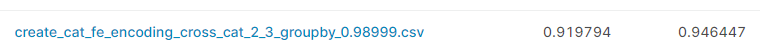
提高了千4

##  类别与连续值之间的groupby,groupby可以说是kaggle的常用也是很方便的技巧，好处很多，最重要的是可以产生大量的新的信息并且很多时候是有逻辑意义的

根据特征重要性进行特征交叉

In [18]:
imp_con=['V258','C13','C1','card1_FE','V294','TransactionAmt','V257','addr1_FE','D2']

In [19]:
for col in drops:
    total_cat.remove(col)

In [20]:
total_cat

['card1',
 'card2',
 'R_emaildomain',
 'ProductCD',
 'addr1',
 'M4',
 'M6',
 'ProductCD_M4',
 'ProductCD_M6',
 'M4_M6',
 'card1_R_emaildomain_addr1',
 'card2_R_emaildomain_addr1',
 'R_emaildomain_ProductCD_addr1',
 'ProductCD_addr1_M4',
 'ProductCD_M4_M6',
 'addr1_M4_M6']

### 类别与连续值的交叉

In [21]:

encode_AG(imp_con, total_cat, aggregations=['mean','std'], train_df=X, test_df=X_test, 
              fillna=False, usena=False)

'V258_card1_mean' , 'V258_card1_std' , 'V258_card2_mean' , 'V258_card2_std' , 'V258_R_emaildomain_mean' , 'V258_R_emaildomain_std' , 'V258_ProductCD_mean' , 'V258_ProductCD_std' , 'V258_addr1_mean' , 'V258_addr1_std' , 'V258_M4_mean' , 'V258_M4_std' , 'V258_M6_mean' , 'V258_M6_std' , 'V258_ProductCD_M4_mean' , 'V258_ProductCD_M4_std' , 'V258_ProductCD_M6_mean' , 'V258_ProductCD_M6_std' , 'V258_M4_M6_mean' , 'V258_M4_M6_std' , 'V258_card1_R_emaildomain_addr1_mean' , 'V258_card1_R_emaildomain_addr1_std' , 'V258_card2_R_emaildomain_addr1_mean' , 'V258_card2_R_emaildomain_addr1_std' , 'V258_R_emaildomain_ProductCD_addr1_mean' , 'V258_R_emaildomain_ProductCD_addr1_std' , 'V258_ProductCD_addr1_M4_mean' , 'V258_ProductCD_addr1_M4_std' , 'V258_ProductCD_M4_M6_mean' , 'V258_ProductCD_M4_M6_std' , 'V258_addr1_M4_M6_mean' , 'V258_addr1_M4_M6_std' , 'C13_card1_mean' , 'C13_card1_std' , 'C13_card2_mean' , 'C13_card2_std' , 'C13_R_emaildomain_mean' , 'C13_R_emaildomain_std' , 'C13_ProductCD_mean' , 

In [22]:
tp=['V258_card1_mean' , 'V258_card1_std' , 'V258_card2_mean' , 'V258_card2_std' , 'V258_R_emaildomain_mean' , 'V258_R_emaildomain_std' , 'V258_ProductCD_mean' , 'V258_ProductCD_std' , 'V258_addr1_mean' , 'V258_addr1_std' , 'V258_M4_mean' , 'V258_M4_std' , 'V258_M6_mean' , 'V258_M6_std' , 'V258_ProductCD_M4_mean' , 'V258_ProductCD_M4_std' , 'V258_ProductCD_M6_mean' , 'V258_ProductCD_M6_std' , 'V258_M4_M6_mean' , 'V258_M4_M6_std' , 'V258_card1_R_emaildomain_addr1_mean' , 'V258_card1_R_emaildomain_addr1_std' , 'V258_card2_R_emaildomain_addr1_mean' , 'V258_card2_R_emaildomain_addr1_std' , 'V258_R_emaildomain_ProductCD_addr1_mean' , 'V258_R_emaildomain_ProductCD_addr1_std' , 'V258_ProductCD_addr1_M4_mean' , 'V258_ProductCD_addr1_M4_std' , 'V258_ProductCD_M4_M6_mean' , 'V258_ProductCD_M4_M6_std' , 'V258_addr1_M4_M6_mean' , 'V258_addr1_M4_M6_std' , 'C13_card1_mean' , 'C13_card1_std' , 'C13_card2_mean' , 'C13_card2_std' , 'C13_R_emaildomain_mean' , 'C13_R_emaildomain_std' , 'C13_ProductCD_mean' , 'C13_ProductCD_std' , 'C13_addr1_mean' , 'C13_addr1_std' , 'C13_M4_mean' , 'C13_M4_std' , 'C13_M6_mean' , 'C13_M6_std' , 'C13_ProductCD_M4_mean' , 'C13_ProductCD_M4_std' , 'C13_ProductCD_M6_mean' , 'C13_ProductCD_M6_std' , 'C13_M4_M6_mean' , 'C13_M4_M6_std' , 'C13_card1_R_emaildomain_addr1_mean' , 'C13_card1_R_emaildomain_addr1_std' , 'C13_card2_R_emaildomain_addr1_mean' , 'C13_card2_R_emaildomain_addr1_std' , 'C13_R_emaildomain_ProductCD_addr1_mean' , 'C13_R_emaildomain_ProductCD_addr1_std' , 'C13_ProductCD_addr1_M4_mean' , 'C13_ProductCD_addr1_M4_std' , 'C13_ProductCD_M4_M6_mean' , 'C13_ProductCD_M4_M6_std' , 'C13_addr1_M4_M6_mean' , 'C13_addr1_M4_M6_std' , 'C1_card1_mean' , 'C1_card1_std' , 'C1_card2_mean' , 'C1_card2_std' , 'C1_R_emaildomain_mean' , 'C1_R_emaildomain_std' , 'C1_ProductCD_mean' , 'C1_ProductCD_std' , 'C1_addr1_mean' , 'C1_addr1_std' , 'C1_M4_mean' , 'C1_M4_std' , 'C1_M6_mean' , 'C1_M6_std' , 'C1_ProductCD_M4_mean' , 'C1_ProductCD_M4_std' , 'C1_ProductCD_M6_mean' , 'C1_ProductCD_M6_std' , 'C1_M4_M6_mean' , 'C1_M4_M6_std' , 'C1_card1_R_emaildomain_addr1_mean' , 'C1_card1_R_emaildomain_addr1_std' , 'C1_card2_R_emaildomain_addr1_mean' , 'C1_card2_R_emaildomain_addr1_std' , 'C1_R_emaildomain_ProductCD_addr1_mean' , 'C1_R_emaildomain_ProductCD_addr1_std' , 'C1_ProductCD_addr1_M4_mean' , 'C1_ProductCD_addr1_M4_std' , 'C1_ProductCD_M4_M6_mean' , 'C1_ProductCD_M4_M6_std' , 'C1_addr1_M4_M6_mean' , 'C1_addr1_M4_M6_std' , 'card1_FE_card1_mean' , 'card1_FE_card1_std' , 'card1_FE_card2_mean' , 'card1_FE_card2_std' , 'card1_FE_R_emaildomain_mean' , 'card1_FE_R_emaildomain_std' , 'card1_FE_ProductCD_mean' , 'card1_FE_ProductCD_std' , 'card1_FE_addr1_mean' , 'card1_FE_addr1_std' , 'card1_FE_M4_mean' , 'card1_FE_M4_std' , 'card1_FE_M6_mean' , 'card1_FE_M6_std' , 'card1_FE_ProductCD_M4_mean' , 'card1_FE_ProductCD_M4_std' , 'card1_FE_ProductCD_M6_mean' , 'card1_FE_ProductCD_M6_std' , 'card1_FE_M4_M6_mean' , 'card1_FE_M4_M6_std' , 'card1_FE_card1_R_emaildomain_addr1_mean' , 'card1_FE_card1_R_emaildomain_addr1_std' , 'card1_FE_card2_R_emaildomain_addr1_mean' , 'card1_FE_card2_R_emaildomain_addr1_std' , 'card1_FE_R_emaildomain_ProductCD_addr1_mean' , 'card1_FE_R_emaildomain_ProductCD_addr1_std' , 'card1_FE_ProductCD_addr1_M4_mean' , 'card1_FE_ProductCD_addr1_M4_std' , 'card1_FE_ProductCD_M4_M6_mean' , 'card1_FE_ProductCD_M4_M6_std' , 'card1_FE_addr1_M4_M6_mean' , 'card1_FE_addr1_M4_M6_std' , 'V294_card1_mean' , 'V294_card1_std' , 'V294_card2_mean' , 'V294_card2_std' , 'V294_R_emaildomain_mean' , 'V294_R_emaildomain_std' , 'V294_ProductCD_mean' , 'V294_ProductCD_std' , 'V294_addr1_mean' , 'V294_addr1_std' , 'V294_M4_mean' , 'V294_M4_std' , 'V294_M6_mean' , 'V294_M6_std' , 'V294_ProductCD_M4_mean' , 'V294_ProductCD_M4_std' , 'V294_ProductCD_M6_mean' , 'V294_ProductCD_M6_std' , 'V294_M4_M6_mean' , 'V294_M4_M6_std' , 'V294_card1_R_emaildomain_addr1_mean' , 'V294_card1_R_emaildomain_addr1_std' , 'V294_card2_R_emaildomain_addr1_mean' , 'V294_card2_R_emaildomain_addr1_std' , 'V294_R_emaildomain_ProductCD_addr1_mean' , 'V294_R_emaildomain_ProductCD_addr1_std' , 'V294_ProductCD_addr1_M4_mean' , 'V294_ProductCD_addr1_M4_std' , 'V294_ProductCD_M4_M6_mean' , 'V294_ProductCD_M4_M6_std' , 'V294_addr1_M4_M6_mean' , 'V294_addr1_M4_M6_std' , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card2_mean' , 'TransactionAmt_card2_std' , 'TransactionAmt_R_emaildomain_mean' , 'TransactionAmt_R_emaildomain_std' , 'TransactionAmt_ProductCD_mean' , 'TransactionAmt_ProductCD_std' , 'TransactionAmt_addr1_mean' , 'TransactionAmt_addr1_std' , 'TransactionAmt_M4_mean' , 'TransactionAmt_M4_std' , 'TransactionAmt_M6_mean' , 'TransactionAmt_M6_std' , 'TransactionAmt_ProductCD_M4_mean' , 'TransactionAmt_ProductCD_M4_std' , 'TransactionAmt_ProductCD_M6_mean' , 'TransactionAmt_ProductCD_M6_std' , 'TransactionAmt_M4_M6_mean' , 'TransactionAmt_M4_M6_std' , 'TransactionAmt_card1_R_emaildomain_addr1_mean' , 'TransactionAmt_card1_R_emaildomain_addr1_std' , 'TransactionAmt_card2_R_emaildomain_addr1_mean' , 'TransactionAmt_card2_R_emaildomain_addr1_std' , 'TransactionAmt_R_emaildomain_ProductCD_addr1_mean' , 'TransactionAmt_R_emaildomain_ProductCD_addr1_std' , 'TransactionAmt_ProductCD_addr1_M4_mean' , 'TransactionAmt_ProductCD_addr1_M4_std' , 'TransactionAmt_ProductCD_M4_M6_mean' , 'TransactionAmt_ProductCD_M4_M6_std' , 'TransactionAmt_addr1_M4_M6_mean' , 'TransactionAmt_addr1_M4_M6_std' , 'V257_card1_mean' , 'V257_card1_std' , 'V257_card2_mean' , 'V257_card2_std' , 'V257_R_emaildomain_mean' , 'V257_R_emaildomain_std' , 'V257_ProductCD_mean' , 'V257_ProductCD_std' , 'V257_addr1_mean' , 'V257_addr1_std' , 'V257_M4_mean' , 'V257_M4_std' , 'V257_M6_mean' , 'V257_M6_std' , 'V257_ProductCD_M4_mean' , 'V257_ProductCD_M4_std' , 'V257_ProductCD_M6_mean' , 'V257_ProductCD_M6_std' , 'V257_M4_M6_mean' , 'V257_M4_M6_std' , 'V257_card1_R_emaildomain_addr1_mean' , 'V257_card1_R_emaildomain_addr1_std' , 'V257_card2_R_emaildomain_addr1_mean' , 'V257_card2_R_emaildomain_addr1_std' , 'V257_R_emaildomain_ProductCD_addr1_mean' , 'V257_R_emaildomain_ProductCD_addr1_std' , 'V257_ProductCD_addr1_M4_mean' , 'V257_ProductCD_addr1_M4_std' , 'V257_ProductCD_M4_M6_mean' , 'V257_ProductCD_M4_M6_std' , 'V257_addr1_M4_M6_mean' , 'V257_addr1_M4_M6_std' , 'addr1_FE_card1_mean' , 'addr1_FE_card1_std' , 'addr1_FE_card2_mean' , 'addr1_FE_card2_std' , 'addr1_FE_R_emaildomain_mean' , 'addr1_FE_R_emaildomain_std' , 'addr1_FE_ProductCD_mean' , 'addr1_FE_ProductCD_std' , 'addr1_FE_addr1_mean' , 'addr1_FE_addr1_std' , 'addr1_FE_M4_mean' , 'addr1_FE_M4_std' , 'addr1_FE_M6_mean' , 'addr1_FE_M6_std' , 'addr1_FE_ProductCD_M4_mean' , 'addr1_FE_ProductCD_M4_std' , 'addr1_FE_ProductCD_M6_mean' , 'addr1_FE_ProductCD_M6_std' , 'addr1_FE_M4_M6_mean' , 'addr1_FE_M4_M6_std' , 'addr1_FE_card1_R_emaildomain_addr1_mean' , 'addr1_FE_card1_R_emaildomain_addr1_std' , 'addr1_FE_card2_R_emaildomain_addr1_mean' , 'addr1_FE_card2_R_emaildomain_addr1_std' , 'addr1_FE_R_emaildomain_ProductCD_addr1_mean' , 'addr1_FE_R_emaildomain_ProductCD_addr1_std' , 'addr1_FE_ProductCD_addr1_M4_mean' , 'addr1_FE_ProductCD_addr1_M4_std' , 'addr1_FE_ProductCD_M4_M6_mean' , 'addr1_FE_ProductCD_M4_M6_std' , 'addr1_FE_addr1_M4_M6_mean' , 'addr1_FE_addr1_M4_M6_std' , 'D2_card1_mean' , 'D2_card1_std' , 'D2_card2_mean' , 'D2_card2_std' , 'D2_R_emaildomain_mean' , 'D2_R_emaildomain_std' , 'D2_ProductCD_mean' , 'D2_ProductCD_std' , 'D2_addr1_mean' , 'D2_addr1_std' , 'D2_M4_mean' , 'D2_M4_std' , 'D2_M6_mean' , 'D2_M6_std' , 'D2_ProductCD_M4_mean' , 'D2_ProductCD_M4_std' , 'D2_ProductCD_M6_mean' , 'D2_ProductCD_M6_std' , 'D2_M4_M6_mean' , 'D2_M4_M6_std' , 'D2_card1_R_emaildomain_addr1_mean' , 'D2_card1_R_emaildomain_addr1_std' , 'D2_card2_R_emaildomain_addr1_mean' , 'D2_card2_R_emaildomain_addr1_std' , 'D2_R_emaildomain_ProductCD_addr1_mean' , 'D2_R_emaildomain_ProductCD_addr1_std' , 'D2_ProductCD_addr1_M4_mean' , 'D2_ProductCD_addr1_M4_std' , 'D2_ProductCD_M4_M6_mean' , 'D2_ProductCD_M4_M6_std' , 'D2_addr1_M4_M6_mean' , 'D2_addr1_M4_M6_std' , ]

In [23]:
drop=X[tp].std()
drop=list(drop[drop==0].index)

In [24]:
drop

['V258_M6_mean',
 'V258_M6_std',
 'card1_FE_card1_std',
 'card1_FE_card1_R_emaildomain_addr1_std',
 'V257_M6_mean',
 'V257_M6_std',
 'addr1_FE_addr1_std',
 'addr1_FE_card1_R_emaildomain_addr1_std',
 'addr1_FE_card2_R_emaildomain_addr1_std',
 'addr1_FE_R_emaildomain_ProductCD_addr1_std',
 'addr1_FE_ProductCD_addr1_M4_std',
 'addr1_FE_addr1_M4_M6_std']

In [25]:
X.drop(drop,axis=1,inplace=True)
X_test.drop(drop,axis=1,inplace=True)

In [26]:
for col in drop:
    tp.remove(col)

In [46]:
groups,ratio=nan_search(X[tp])

####### NAN count = 27083
####### NAN ratio = 0.045861414976123546
['V258_card1_mean', 'V257_card1_mean']


####### NAN count = 45647
####### NAN ratio = 0.07729705015748298
['V258_card1_std', 'V257_card1_std']


####### NAN count = 2445
####### NAN ratio = 0.004140278389270837
['V258_card2_mean', 'V257_card2_mean']


####### NAN count = 3487
####### NAN ratio = 0.005904765130219799
['V258_card2_std', 'V257_card2_std']


####### NAN count = 0
####### NAN ratio = 0.0
['V258_R_emaildomain_mean', 'V258_R_emaildomain_std', 'V258_M4_mean', 'V258_M4_std', 'C13_card1_mean', 'C13_card2_mean', 'C13_card2_std', 'C13_R_emaildomain_mean', 'C13_R_emaildomain_std', 'C13_ProductCD_mean', 'C13_ProductCD_std', 'C13_addr1_mean', 'C13_M4_mean', 'C13_M4_std', 'C13_M6_mean', 'C13_M6_std', 'C13_ProductCD_M4_mean', 'C13_ProductCD_M4_std', 'C13_ProductCD_M6_mean', 'C13_ProductCD_M6_std', 'C13_M4_M6_mean', 'C13_M4_M6_std', 'C13_card1_R_emaildomain_addr1_mean', 'C13_card2_R_emaildomain_addr1_mean', 'C13_R_email

In [27]:
groups=[['V258_ProductCD_mean', 'V258_ProductCD_std', 'V258_ProductCD_M4_mean', 'V258_ProductCD_M4_std', 'V258_ProductCD_M6_mean', 'V258_ProductCD_M6_std', 'V258_ProductCD_M4_M6_mean', 'V258_ProductCD_M4_M6_std', 'V257_ProductCD_mean', 'V257_ProductCD_std', 'V257_ProductCD_M4_mean', 'V257_ProductCD_M4_std', 'V257_ProductCD_M6_mean', 'V257_ProductCD_M6_std', 'V257_ProductCD_M4_M6_mean', 'V257_ProductCD_M4_M6_std'],
       ['V258_M4_M6_mean', 'V258_M4_M6_std', 'V257_M4_M6_mean', 'V257_M4_M6_std'],['V258_card1_R_emaildomain_addr1_mean', 'V257_card1_R_emaildomain_addr1_mean'],
       ['V258_card1_R_emaildomain_addr1_std', 'V257_card1_R_emaildomain_addr1_std'],['V258_card2_R_emaildomain_addr1_mean', 'V257_card2_R_emaildomain_addr1_mean','V258_card2_R_emaildomain_addr1_std', 'V257_card2_R_emaildomain_addr1_std'],
       ['V258_ProductCD_addr1_M4_mean', 'V257_ProductCD_addr1_M4_mean','V258_ProductCD_addr1_M4_std', 'V257_ProductCD_addr1_M4_std'],['V258_addr1_M4_M6_mean', 'V257_addr1_M4_M6_mean','V258_addr1_M4_M6_std', 'V257_addr1_M4_M6_std'],
       ]

In [28]:
for group in groups:
    for col in group:
        tp.remove(col)

In [29]:
groups.append(tp)

In [69]:

for value in [0.79999,0.89999,0.98999]:
    drops=[]
    for group in groups:
        corr_matrix_spearman=X[group].rank().corr()
        corr_matrix_pearson=X[group].corr()
        _,drops_spearman=identify_collinear(corr_matrix_spearman,value,X)
        _,drops_pearson=identify_collinear(corr_matrix_pearson,value,X)
        if drops_spearman=='nothing!':
            drops_spearman=[]
        if drops_pearson=='nothing!':
            drops_pearson=[]
        drops=drops+(drops_spearman+drops_pearson)

    drops=list(set(drops))
    cols=list(X.columns)
    cols.remove('TransactionDT')
    for col in drops:
        cols.remove(col)
    clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=200,cols=cols,categorical_feature=None,group_feature=None)
    #X_test[cat]=X_test[cat].astype(np.int64)
    y_pred=np.zeros(X_test.shape[0])
    for clf in clfs:
        y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
    sub=pd.read_csv(r'F:\kaggle_ieee\sample_submission.csv')
    sub['isFraud']=y_pred
    sub.to_csv(r'F:\kaggle_ieee\submit\create_cat_fe_encoding_cross_cat_2_3_groupby_'+str(value)+'.csv',index=False)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.964116	valid_1's auc: 0.893441
[200]	training's auc: 0.979334	valid_1's auc: 0.904418
[300]	training's auc: 0.989098	valid_1's auc: 0.911368
[400]	training's auc: 0.994396	valid_1's auc: 0.91568
[500]	training's auc: 0.997128	valid_1's auc: 0.918607
[600]	training's auc: 0.998502	valid_1's auc: 0.92
[700]	training's auc: 0.999197	valid_1's auc: 0.920592
[800]	training's auc: 0.999555	valid_1's auc: 0.92068
[900]	training's auc: 0.99975	valid_1's auc: 0.920882
[1000]	training's auc: 0.999861	valid_1's auc: 0.920809
[1100]	training's auc: 0.999921	valid_1's auc: 0.920715
Early stopping, best iteration is:
[918]	training's auc: 0.999777	valid_1's auc: 0.920971
Fold 1 | AUC: 0.9209713328832969
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.963437	valid_1's auc: 0.917099
[200]	training's auc: 0.979912	valid_1's auc: 0.928499
[300]	training's auc: 0.989842	valid_1's au

Mean AUC = 0.9391052431881411    0.7999
Out of folds AUC = 0.9404255998086899
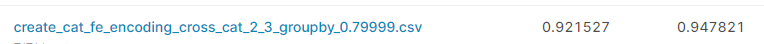



Mean AUC = 0.93921961533078    0.8999
Out of folds AUC = 0.9392373510453308
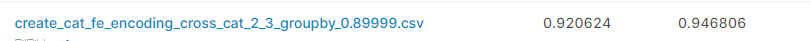


Mean AUC = 0.9386304514946641  0.98999
Out of folds AUC = 0.9381450236966348
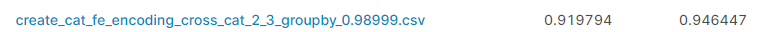

可以看到，阈值卡到0.7999的时候虽然线下略低于0.89999万一，但是线上a榜得分最高，高了整整千一，因此我们就卡到0.7999

这里还是可以细致调整参数的，不过出于时间考虑。。。就不做那么细致了。。。，根据相关系数删除多余的特征节约内存空间提高运行效率

通过上述的几组测试，我们发现，基于相关性的特征选择也不是放之四海而皆有效的，我们一开始处理V特征的时候阈值卡到0.75反而起到了很好的效果，后续不同的相关系数设置与local cv的分数存在非线性的关系，
最简单暴力的方法就是不同的参数都试试。。。。虽然确实有点费时间

## 超参数的调整

因为贝叶斯优化等超参数调参的方法太耗费时间了，线下可以自己找找模板跑一跑，这里直接使用baseline里别的选手使用的参数设置

https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm  超参数来源

In [46]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'colsample_bytree': 0.3797454081646243,
          'subsample': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'n_estimators':100000
         }

In [27]:
drops=[]
for group in groups:
    corr_matrix_spearman=X[group].rank().corr()
    corr_matrix_pearson=X[group].corr()
    _,drops_spearman=identify_collinear(corr_matrix_spearman,0.74999,X)
    _,drops_pearson=identify_collinear(corr_matrix_pearson,0.74999,X)
    if drops_spearman=='nothing!':
        drops_spearman=[]
    if drops_pearson=='nothing!':
        drops_pearson=[]
    drops=drops+(drops_spearman+drops_pearson)

drops=list(set(drops))
X.drop(drops,axis=1,inplace=True)
X_test.drop(drops,axis=1,inplace=True)

In [30]:

cols=list(X.columns)
cols.remove('TransactionDT')
clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=500,cols=cols,categorical_feature=None,group_feature=None)
#X_test[cat]=X_test[cat].astype(np.int64)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
sub=pd.read_csv(r'F:\kaggle_ieee\sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv(r'F:\kaggle_ieee\submit\create_cat_fe_encoding_cross_cat_2_3_groupby_change_params.csv',index=False)


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.955292	valid_1's auc: 0.885827
[200]	training's auc: 0.967655	valid_1's auc: 0.893343
[300]	training's auc: 0.9776	valid_1's auc: 0.899945
[400]	training's auc: 0.984792	valid_1's auc: 0.905681
[500]	training's auc: 0.989686	valid_1's auc: 0.910119
[600]	training's auc: 0.992989	valid_1's auc: 0.912885
[700]	training's auc: 0.995204	valid_1's auc: 0.914677
[800]	training's auc: 0.996696	valid_1's auc: 0.916293
[900]	training's auc: 0.997733	valid_1's auc: 0.917471
[1000]	training's auc: 0.998415	valid_1's auc: 0.918446
[1100]	training's auc: 0.998896	valid_1's auc: 0.919129
[1200]	training's auc: 0.999219	valid_1's auc: 0.919506
[1300]	training's auc: 0.999444	valid_1's auc: 0.919797
[1400]	training's auc: 0.999606	valid_1's auc: 0.920063
[1500]	training's auc: 0.999725	valid_1's auc: 0.920017
[1600]	training's auc: 0.999804	valid_1's auc: 0.920062
[1700]	training's auc: 0.99986	valid_1's auc: 0.92015

NameError: name 'models' is not defined

Mean AUC = 0.9394737973237505
Out of folds AUC = 0.9394359765074326  目前最高local CV

## 到此为止，整体套路做的差不多了，然后接着是一些细节的处理上

然后就是开源kernel的一些特征可以尝试放进来看看有没有效果，下面的这些特征均来自开源kernel

### 1、nan值用-99999补充之后看看结果；

In [ ]:
100000,99000都是nan，1000样本，nan -99999，

In [38]:
X.min().min()

-193.0

In [32]:
X_test.isnull().sum()

TransactionDT                  0
TransactionAmt                 0
ProductCD                      0
card1                          0
card2                          0
                            ... 
D2_ProductCD_addr1_M4_std    498
D2_ProductCD_M4_M6_mean        0
D2_ProductCD_M4_M6_std         0
D2_addr1_M4_M6_mean          271
D2_addr1_M4_M6_std           503
Length: 498, dtype: int64

In [39]:
X_test.min().min()

-100.0

In [42]:
X[total_cat].isnull().sum()

card1                            0
card2                            0
R_emaildomain                    0
ProductCD                        0
addr1                            0
M4                               0
M6                               0
ProductCD_M4                     0
ProductCD_M6                     0
M4_M6                            0
card1_R_emaildomain_addr1        0
card2_R_emaildomain_addr1        0
R_emaildomain_ProductCD_addr1    0
ProductCD_addr1_M4               0
ProductCD_M4_M6                  0
addr1_M4_M6                      0
dtype: int64

In [44]:
X_test[total_cat].isnull().sum()

card1                            0
card2                            0
R_emaildomain                    0
ProductCD                        0
addr1                            0
M4                               0
M6                               0
ProductCD_M4                     0
ProductCD_M6                     0
M4_M6                            0
card1_R_emaildomain_addr1        0
card2_R_emaildomain_addr1        0
R_emaildomain_ProductCD_addr1    0
ProductCD_addr1_M4               0
ProductCD_M4_M6                  0
addr1_M4_M6                      0
dtype: int64

In [45]:
X.fillna(-99999,inplace=True)
X_test.fillna(-99999,inplace=True)

In [47]:


cols=list(X.columns)
cols.remove('TransactionDT')
clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=500,cols=cols,categorical_feature=None,group_feature=None)
#X_test[cat]=X_test[cat].astype(np.int64)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
sub=pd.read_csv(r'F:\kaggle_ieee\sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv(r'F:\kaggle_ieee\submit\create_cat_fe_encoding_cross_cat_2_3_groupby_change_params_fillna-99999.csv',index=False)

Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.953173	valid_1's auc: 0.883842
[200]	training's auc: 0.964862	valid_1's auc: 0.891806
[300]	training's auc: 0.975042	valid_1's auc: 0.898821
[400]	training's auc: 0.982526	valid_1's auc: 0.904796
[500]	training's auc: 0.98783	valid_1's auc: 0.909554
[600]	training's auc: 0.991498	valid_1's auc: 0.91296
[700]	training's auc: 0.993998	valid_1's auc: 0.91525
[800]	training's auc: 0.995781	valid_1's auc: 0.916842
[900]	training's auc: 0.996998	valid_1's auc: 0.918026
[1000]	training's auc: 0.997857	valid_1's auc: 0.918823
[1100]	training's auc: 0.998458	valid_1's auc: 0.919411
[1200]	training's auc: 0.998886	valid_1's auc: 0.919774
[1300]	training's auc: 0.999185	valid_1's auc: 0.919809
[1400]	training's auc: 0.999413	valid_1's auc: 0.919963
[1500]	training's auc: 0.999574	valid_1's auc: 0.920049
[1600]	training's auc: 0.999686	valid_1's auc: 0.92012
[1700]	training's auc: 0.999767	valid_1's auc: 0.920117

### 使用groupby作为交叉验证的方式

In [48]:
X.replace(-99999,np.nan,inplace=True)
X_test.replace(-99999,np.nan,inplace=True)

In [49]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X['DT_M'] = X['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X['DT_M'] = (X['DT_M'].dt.year-2017)*12 + X['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

In [53]:
cols=list(X.columns)
cols.remove('TransactionDT')
clfs=lgb_model(params=params,cv=GroupKFold(6),X=X,y=y,early_stopping_rounds=500,cols=cols,categorical_feature=None,group_feature='DT_M')
#X_test[cat]=X_test[cat].astype(np.int64)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/6
sub=pd.read_csv(r'F:\kaggle_ieee\sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv(r'F:\kaggle_ieee\submit\create_cat_fe_encoding_cross_cat_2_3_groupby_change_params_groupkfold.csv',index=False)

Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.954537	valid_1's auc: 0.883074
[200]	training's auc: 0.966139	valid_1's auc: 0.890636
[300]	training's auc: 0.976307	valid_1's auc: 0.897733
[400]	training's auc: 0.983824	valid_1's auc: 0.903738
[500]	training's auc: 0.988967	valid_1's auc: 0.908459
[600]	training's auc: 0.992508	valid_1's auc: 0.911825
[700]	training's auc: 0.994867	valid_1's auc: 0.913737
[800]	training's auc: 0.996474	valid_1's auc: 0.915222
[900]	training's auc: 0.997565	valid_1's auc: 0.916305
[1000]	training's auc: 0.998297	valid_1's auc: 0.917006
[1100]	training's auc: 0.998811	valid_1's auc: 0.917587
[1200]	training's auc: 0.99916	valid_1's auc: 0.917914
[1300]	training's auc: 0.999402	valid_1's auc: 0.91807
[1400]	training's auc: 0.999583	valid_1's auc: 0.918225
[1500]	training's auc: 0.999706	valid_1's auc: 0.91826
[1600]	training's auc: 0.999795	valid_1's auc: 0.918394
[1700]	training's auc: 0.999852	valid_1's auc: 0.91843

[2000]	training's auc: 0.999909	valid_1's auc: 0.957079
[2100]	training's auc: 0.999933	valid_1's auc: 0.9571
[2200]	training's auc: 0.99995	valid_1's auc: 0.957056
[2300]	training's auc: 0.999962	valid_1's auc: 0.957039
Early stopping, best iteration is:
[1802]	training's auc: 0.999842	valid_1's auc: 0.957207
Fold 6 | AUC: 0.9572067449697732

Mean AUC = 1.132926325548367
Out of folds AUC = 0.9407317655575583


1.132926325548367*5/6  #这里算错了。。。因为用了6折交叉验证，而除的时候只除了5
 0.9441052712903059

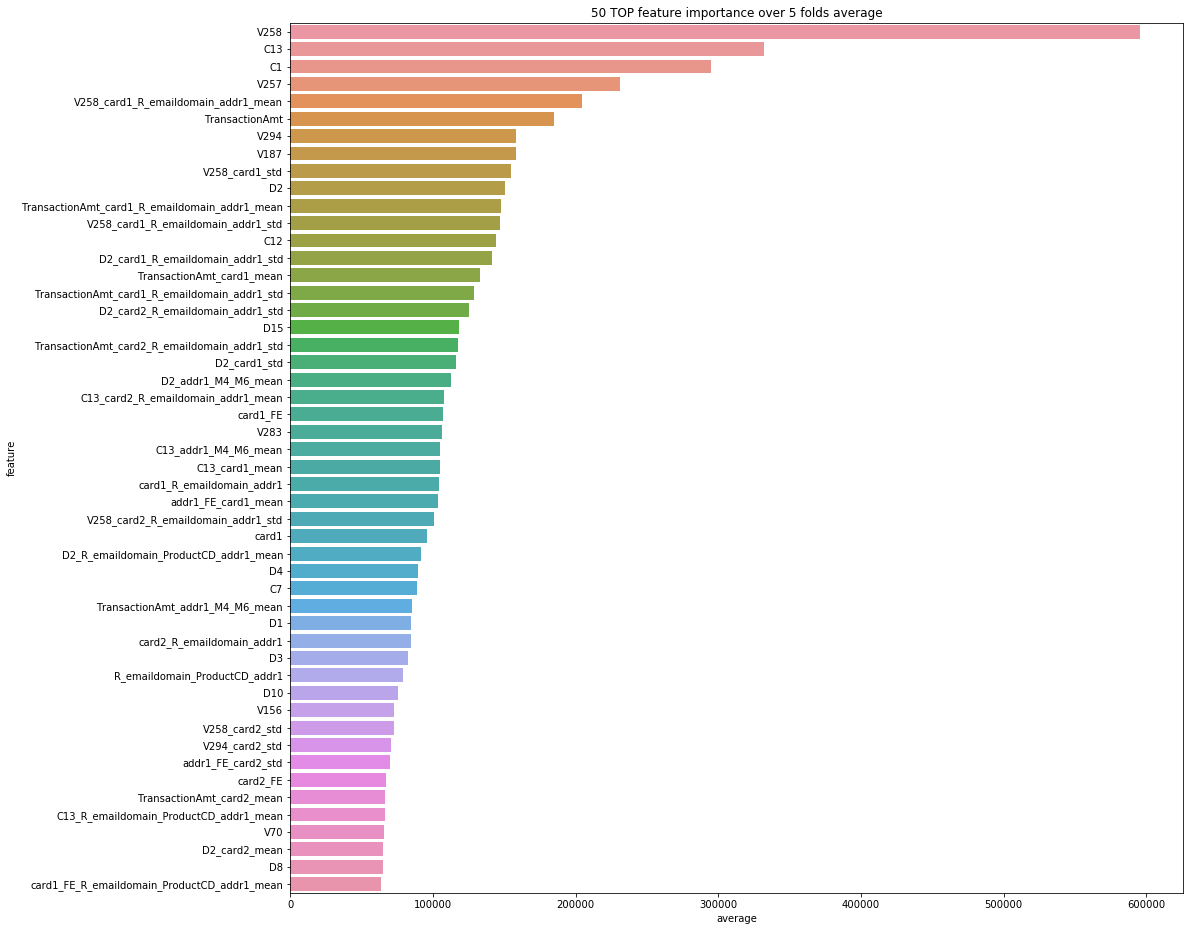

In [104]:
cols=list(X.columns)
cols.remove('TransactionDT')
cols.remove('DT_M')
feature_importances=get_imp(clfs,imp_type='gain',feature_names=cols)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(5));

# magic  feature

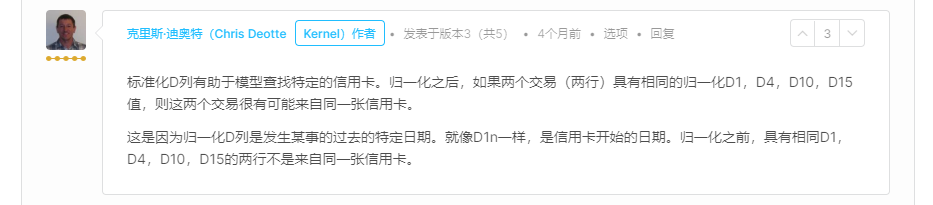

In [63]:
X['card1_addr1']=X.card1.astype(str)+'_'+X.addr1.astype(str)
X_test['card1_addr1']=X_test.card1.astype(str)+'_'+X_test.addr1.astype(str)

In [64]:
X['day'] = X.TransactionDT / (24*60*60)
X['uid'] = X.card1_addr1.astype(str)+'_'+np.floor(X.day-X.D1).astype(str)
X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

In [65]:
X.drop(['card1_addr1'],axis=1,inplace=True)
X_test.drop(['card1_addr1'],axis=1,inplace=True)

In [66]:
X_train=X

有一些冗余特征之前删除了，所以做了一些小改动

In [76]:
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')

cents, 

In [ ]:
0.154

In [ ]:
120000.154

In [78]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C1',
 'C3',
 'C5',
 'C7',
 'C9',
 'C12',
 'C13',],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)

# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C3_uid_mean' , 'C5_uid_mean' , 'C7_uid_mean' , 'C9_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15
Wall time: 1min 43s


In [109]:
cols=list(X.columns)
cols.remove('TransactionDT')
cols.remove('uid')
clfs=lgb_model(params=params,cv=GroupKFold(6),X=X,y=y,early_stopping_rounds=500,cols=cols,categorical_feature=None,group_feature='DT_M')
#X_test[cat]=X_test[cat].astype(np.int64)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
sub=pd.read_csv(r'F:\kaggle_ieee\sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv(r'F:\kaggle_ieee\submit\create_cat_fe_encoding_cross_cat_2_3_groupby_change_params_groupkfold_magic.csv',index=False)

Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.96933	valid_1's auc: 0.902215
[200]	training's auc: 0.977911	valid_1's auc: 0.909825
[300]	training's auc: 0.98509	valid_1's auc: 0.915815
[400]	training's auc: 0.990289	valid_1's auc: 0.919973
[500]	training's auc: 0.993896	valid_1's auc: 0.923911
[600]	training's auc: 0.996302	valid_1's auc: 0.926275
[700]	training's auc: 0.997854	valid_1's auc: 0.92776
[800]	training's auc: 0.99881	valid_1's auc: 0.928686
[900]	training's auc: 0.999355	valid_1's auc: 0.929276
[1000]	training's auc: 0.999658	valid_1's auc: 0.929869
[1100]	training's auc: 0.999817	valid_1's auc: 0.930303
[1200]	training's auc: 0.999904	valid_1's auc: 0.930557
[1300]	training's auc: 0.999951	valid_1's auc: 0.930653
[1400]	training's auc: 0.999976	valid_1's auc: 0.930804
[1500]	training's auc: 0.999988	valid_1's auc: 0.930872
[1600]	training's auc: 0.999995	valid_1's auc: 0.930945
[1700]	training's auc: 0.999998	valid_1's auc: 0.93099


[2200]	training's auc: 1	valid_1's auc: 0.97079
[2300]	training's auc: 1	valid_1's auc: 0.970759
Early stopping, best iteration is:
[1802]	training's auc: 0.999998	valid_1's auc: 0.970944
Fold 6 | AUC: 0.9709441983313618

Mean AUC = 1.1505615692580378
Out of folds AUC = 0.9574640188046546


1.1505615692580378*5/6=0.9588

In [110]:
drop=['uid_FE' , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C3_uid_mean' , 'C5_uid_mean' , 'C7_uid_mean' , 'C9_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , 'uid_P_emaildomain_ct', 'uid_dist1_ct', 'uid_DT_M_ct', 'uid_id_02_ct', 'uid_cents_ct', 'uid_C13_ct', 'uid_V314_ct', 'uid_V127_ct', 'uid_V136_ct', 'uid_V309_ct', 'uid_V307_ct', 'uid_V320_ct', 'outsider15']

In [111]:
X.drop(drop,axis=1,inplace=True)
X_test.drop(drop,axis=1,inplace=True)

In [112]:
X_train=X

In [114]:
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['V258','C13','C1','V257','TransactionAmt','V294','V187','D2','C12','D15','V283'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
# AGGREGATE
#encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(total_cat, ['uid'], train_df=X_train, test_df=X_test)

# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_card1_ct, uid_card2_ct, uid_R_emaildomain_ct, uid_ProductCD_ct, uid_addr1_ct, uid_M4_ct, uid_M6_ct, uid_ProductCD_M4_ct, uid_ProductCD_M6_ct, uid_M4_M6_ct, uid_card1_R_emaildomain_addr1_ct, uid_card2_R_emaildomain_addr1_ct, uid_R_emaildomain_ProductCD_addr1_ct, uid_ProductCD_addr1_M4_ct, uid_ProductCD_M4_M6_ct, uid_addr1_M4_M6_ct, outsider15


In [115]:
cols=list(X.columns)
cols.remove('TransactionDT')
cols.remove('uid')
clfs=lgb_model(params=params,cv=GroupKFold(6),X=X,y=y,early_stopping_rounds=500,cols=cols,categorical_feature=None,group_feature='DT_M')
#X_test[cat]=X_test[cat].astype(np.int64)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
sub=pd.read_csv(r'F:\kaggle_ieee\sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv(r'F:\kaggle_ieee\submit\create_cat_fe_encoding_cross_cat_2_3_groupby_change_params_groupkfold_magic2.csv',index=False)

Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.970231	valid_1's auc: 0.904758
[200]	training's auc: 0.979115	valid_1's auc: 0.910716
[300]	training's auc: 0.985879	valid_1's auc: 0.915677
[400]	training's auc: 0.990907	valid_1's auc: 0.919557
[500]	training's auc: 0.994336	valid_1's auc: 0.923106
[600]	training's auc: 0.996623	valid_1's auc: 0.925739
[700]	training's auc: 0.998097	valid_1's auc: 0.927373
[800]	training's auc: 0.998962	valid_1's auc: 0.928465
[900]	training's auc: 0.999441	valid_1's auc: 0.929375
[1000]	training's auc: 0.999703	valid_1's auc: 0.929836
[1100]	training's auc: 0.999844	valid_1's auc: 0.930146
[1200]	training's auc: 0.999918	valid_1's auc: 0.930413
[1300]	training's auc: 0.999959	valid_1's auc: 0.930492
[1400]	training's auc: 0.99998	valid_1's auc: 0.930386
[1500]	training's auc: 0.999991	valid_1's auc: 0.93062
[1600]	training's auc: 0.999996	valid_1's auc: 0.930554
[1700]	training's auc: 0.999998	valid_1's auc: 0.9305

Fold 6 | AUC: 0.9707722619682119

Mean AUC = 1.1495992045016568
Out of folds AUC = 0.9569525502230078


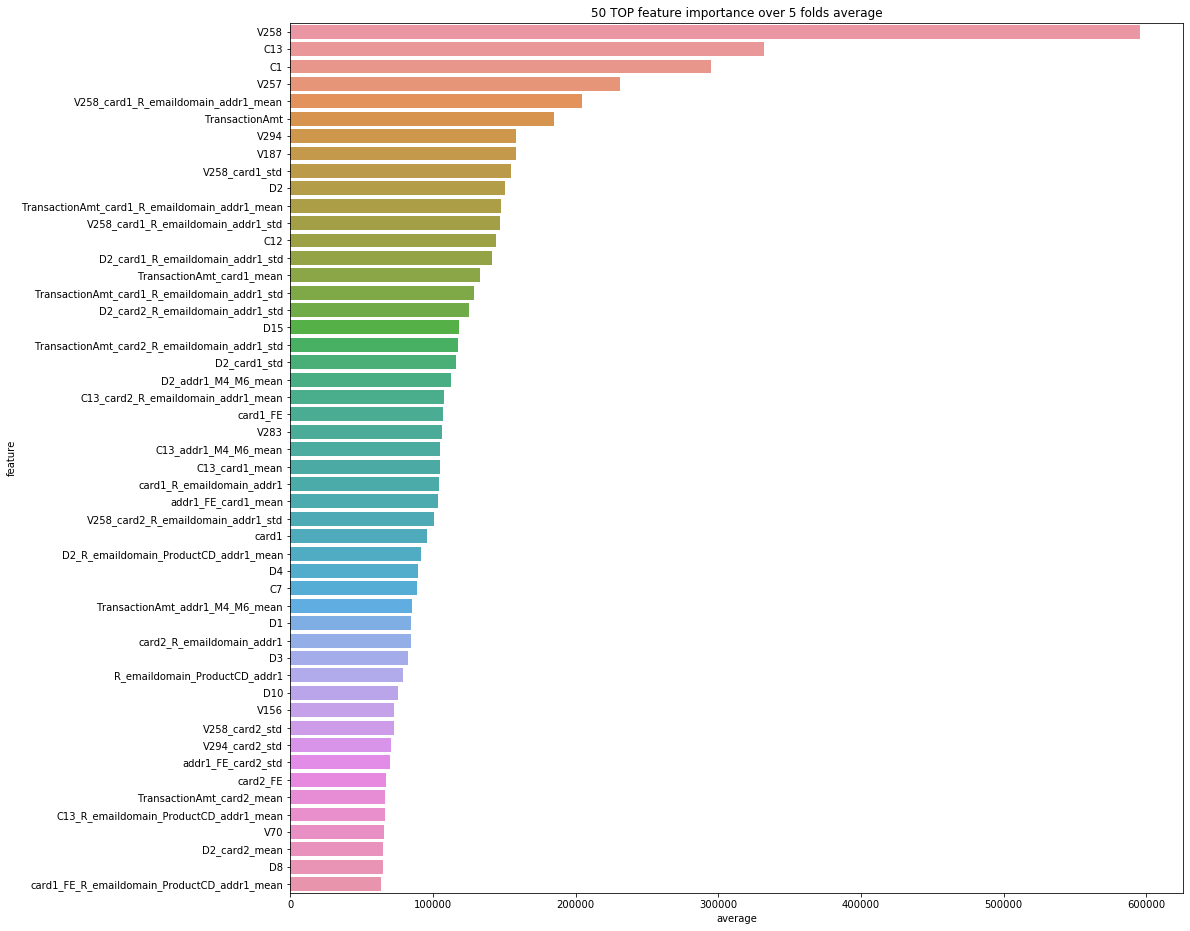

# None

   https://www.kaggle.com/kabure/almost-complete-feature-engineering-ieee-data  额外的特征

https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm 一些新的特征

In [ ]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [ ]:
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

# New feature - decimal part of the transaction amount.
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# New feature - day of week in which a transaction happened.
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

# New feature - hour of the day in which a transaction happened.
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

In [ ]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [ ]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

# None

我们先用用kris验证看看衍生特征的效果如何：

In [234]:
cols=[item for item in list(X.columns) if 'mean' in item or 'std' in item]

In [ ]:
def kris_feature_select(cols=None,X=None,y=None,params=None,cv=KFold(5)):
    
    X['nouse']=0 #lgb无法在单特征上训练(会报错)所以使用一个nouse特征避免错误，因为是常数特征值全都一样所以
    #不用担心影响模型训练过程，模型完全不会在nouse特征上训练的
    for col in cols:
        result=[]
        folds=cv
        splits = folds.split(X[col], y)
        flag=0
        for fold_n, (train_index, valid_index) in enumerate(splits):
            X_train, X_valid = X[[col,'nouse']].iloc[train_index], X[[col,'nouse']].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    
            clf = lgb.LGBMClassifier(n_estimators=500, objective='binary', 
                    num_leaves=491, learning_rate=0.02,n_jobs=1,max_depth=-1)
            h = clf.fit(X_train, y_train, eval_metric='auc', 
                    eval_set=[(X_train,y_train),(X_valid,y_valid)],verbose=-1)
    
            auc_train = np.round(h._best_score['training']['auc'],4)
            auc_val = np.round(h._best_score['valid_1']['auc'],4)
            result.append([flag,auc_train,auc_val,auc_train-auc_val])
    
            del X_train, X_valid, y_train, y_valid,clf
            gc.collect()
        flag+=1
    result=pd.DataFrame(result,columns=['train_auc','valid_auc','auc_delta'])
    return result

In [ ]:
import time
start=time.time()
result=kris_feature_select(cols=cols,X=X,y=y,params=None,cv=KFold(5))
stop=time.time()
print(stop-start)

In [ ]:
def kris_lgb_train(col):
    result=[]
    folds=KFold(5)
    splits = folds.split(X[col], y)
    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = X[[col,'nouse']].iloc[train_index], X[[col,'nouse']].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]


        clf = lgb.LGBMClassifier(n_estimators=500, objective='binary', 
                num_leaves=491, learning_rate=0.02,n_jobs=1,max_depth=-1)
        h = clf.fit(X_train, y_train, eval_metric='auc', 
                eval_set=[(X_train,y_train),(X_valid,y_valid)],verbose=-1)

        auc_train = np.round(h._best_score['training']['auc'],4)
        auc_val = np.round(h._best_score['valid_1']['auc'],4)
        result.append([auc_train,auc_val,auc_train-auc_val])

        del X_train, X_valid, y_train, y_valid,clf
        gc.collect()
    return result

def kris_feature_select(cols=None):
    
    #X['nouse']=0 #lgb无法在单特征上训练(会报错)所以使用一个nouse特征避免错误，因为是常数特征值全都一样所以
    #不用担心影响模型训练过程，模型完全不会在nouse特征上训练的
    result=Parallel(n_jobs=-1)(delayed(kris_lgb_train)(col) for col in cols)
    result=pd.DataFrame(result,columns=['train_auc','valid_auc','auc_delta'])
    return result

In [ ]:
import time
start=time.time()
result2=kris_feature_select(cols=cols)
stop=time.time()
print(stop-start)

In [ ]:
X.drop('C3_ProductCD_mean',axis=1,inplace=True)
X_test.drop('C3_ProductCD_mean',axis=1,inplace=True)


那么应该如何处理比较好？
1、还是使用相关系数，但是使用更严格的相关系数来进行特征的筛选，我们前面使用的是0.94999的阈值，可以通过调参的方式来看看不同相关系数的切分下local cv的结果，比如把阈值卡为0.75，0.85等；
2、在保证原始特征矩阵之间相关性较低的情况下，使用permutation importance\kris的验证方法等更多的特征检验方法来检查哪些特征属于噪声或者会对模型带来不良影响等；
3、超参数的重新调整与设置；

我们前面已经调整了不同的相关系数比较了模型的结果了，kris验证给出的结果是衍生的特征都不错，没有太过偏移的特征；那么接下来我们尝试方案二，使用permutation或者null importance来看看能否找出噪声特征以避免之前使用的方法存在漏网之鱼

In [ ]:
np.random.seed(123)
y_backup=y.values
# Get the actual importance, i.e. without shuffling
cols=list(X.columns)
cols.remove('TransactionDT')
actual_imp_df = get_imp(clfs,imp_type='gain',feature_names=cols)

null_imp_df = pd.DataFrame()
nb_runs = 20
for i in range(nb_runs):
    # Get current run importances
    y=np.random.permutation(y.values)
    clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=200,cols=cols,categorical_feature=None,group_feature=None)
    imp_df = get_imp(clfs,imp_type='gain',feature_names=cols)
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    print('done!')

##### 1\permutation importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
results=[]
for clf in clfs:
    result = permutation_importance(clf, X.drop('TransactionDT',axis=1), y, n_repeats=20, random_state=1234,
                                    n_jobs=-1)

    fig, ax = plt.subplots()
    sorted_idx = result.importances_mean.argsort()
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=range(X.shape[1]))
    ax.set_title("Permutation Importance of each feature")
    ax.set_ylabel("Features")
    fig.tight_layout()
    plt.show()

##### 2\null importance

In [245]:
for i in range(90)

In [249]:
np.random.permutation(y)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

这里需要注意的是，之前我们的特征都是在很小的幅度范围内变动，增减十几个特征左右，整体的特征空间变动不大，所以参数都不调试，但是这里我们goupby的特征进行选择之后还是增加了120个，整体的特征空间发生了巨大的变化，所以参数需要做一些调整。一般来说，维度越高，相对来说数据的可分性越强，模型越容易拟合噪声，即过拟合，所以这里我们需要重新调整一下参数，施加一些更强的约束性参数，
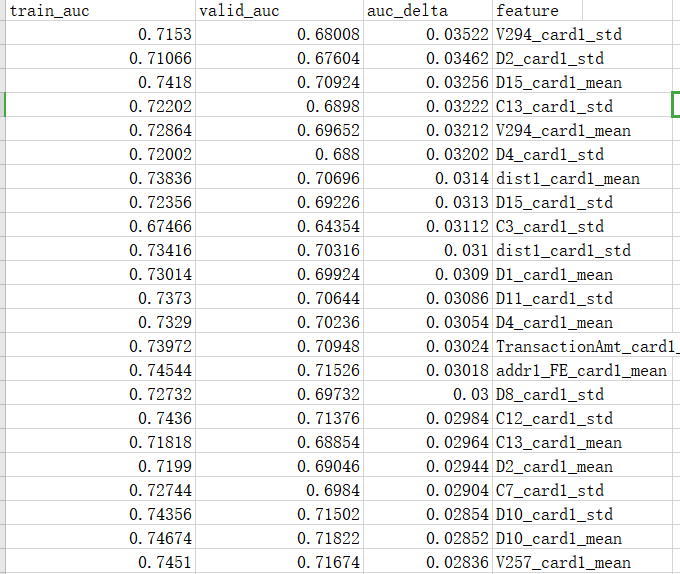
另一方面：可以看到，本身偏移比较严重的card1衍生出来的特征整体偏移也都是最严重的，因此引入的衍生特征可能会放大特征的偏移从而导致模型的过拟合；所以我们就更需要对模型的参数做出调整，尽量降低由于大量特征衍生的引入所产生的潜在的过拟合的效应。


前面我们使用了第一种方案，相关系数的调整，提高了一些得分，考虑到我们后面还要衍生更多的新特征，调参放到最后特征工程实在无法在做的时候再考虑，否则每次增加特征都要重新调参，会非常非常的耗费时间；
那么这里我们直接使用一些常用的超参数组合，或者从开源的kernel上找一些，一般效果都比自己直接设置或者初始化参数要好

https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm  超参数来源

V258,C13,C3,card1_FE,V294,TransactionAmt,V257,addr1_FE,D2,D15,C12,D4,dist1,D10,V187,D1,V70,C7,D8,D11
连续值之间的衍生不想类别之间那样直接交叉那么直观，很多时候加减乘除是没有意义的，所以需要对字段的含义有一定的理解
https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203  左边链接和下图都是官方给到的数据描述

C特征仅知道有部分关于支付卡关联地址数的，id类包括了设备、代理的等级等，transactionamt 交易金额，D系列是时间相关特征显然我们可以和TransactionDT作图看看是否有一定规律，dist是距离特征。。。显然除了D特征可以和TransactionDT相关联之外，其它的特征之间很难去得到有意义的交叉运算，逻辑上没有意义，比如用距离-设备等级或者用代理等级/交易金额，得到数据大概率是噪声特征。

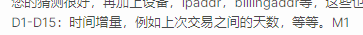
这里我们知道D特征是时间相关的，单位是天数，表示的是时间间隔，因此是一个delta_days的概念，做过风控的应该都清楚，一般在一次的建模任务中用户的起始交易日期都会人为固定的，这样才有时间间隔长短的概念，比如“最近一周”，“最近一个月”这样的概念，必然会选择一个固定的时间节点作为参照，因此，我们可以根据transactionDT和day_delta计算出用户的起始交易日期；当然，这只是猜想，具体的我们还需要进一步验证

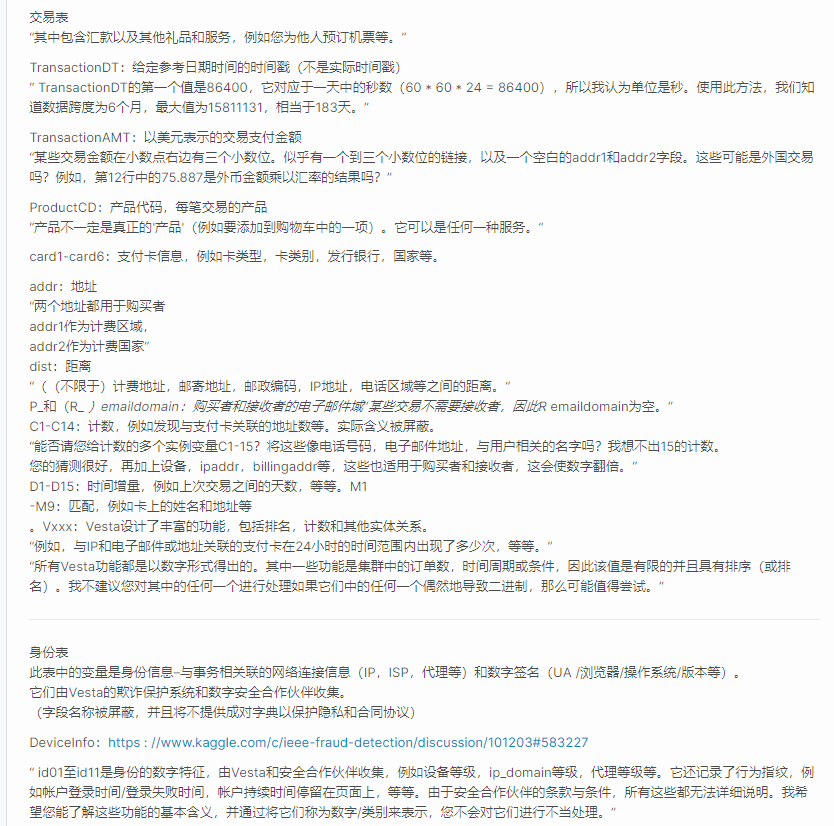


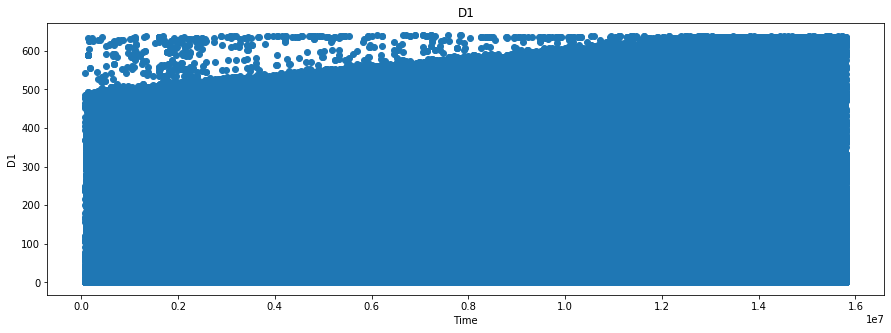

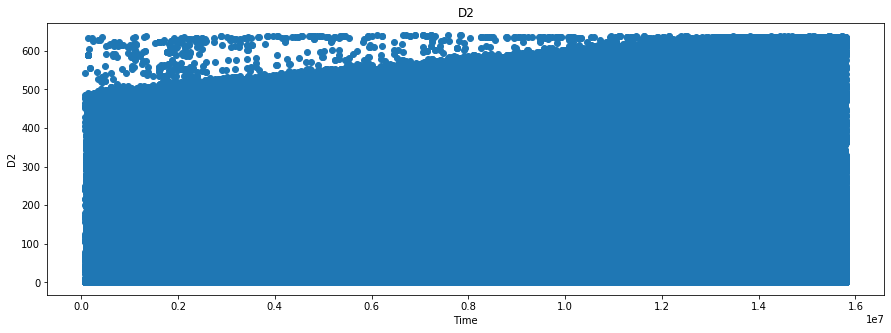

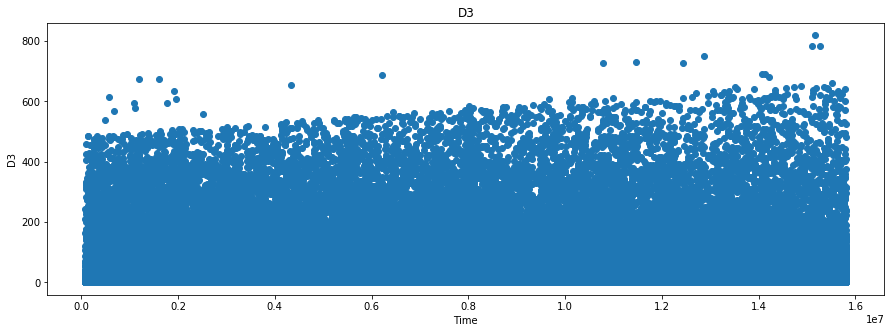

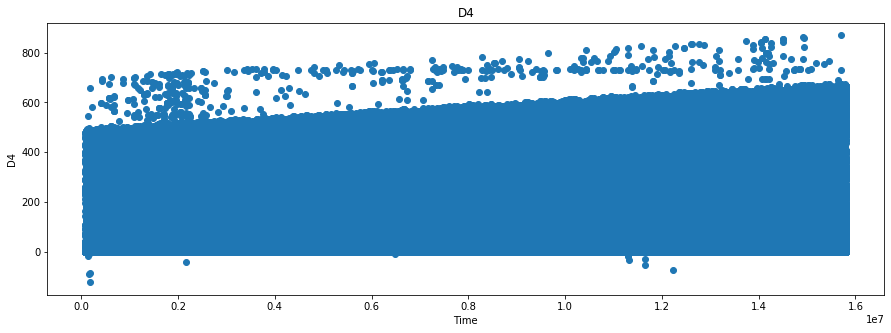

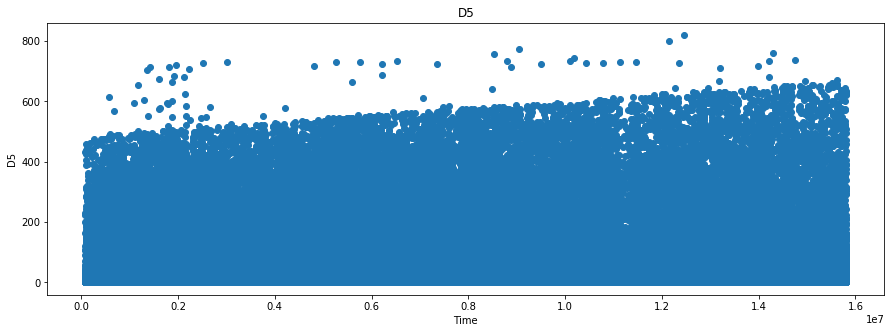

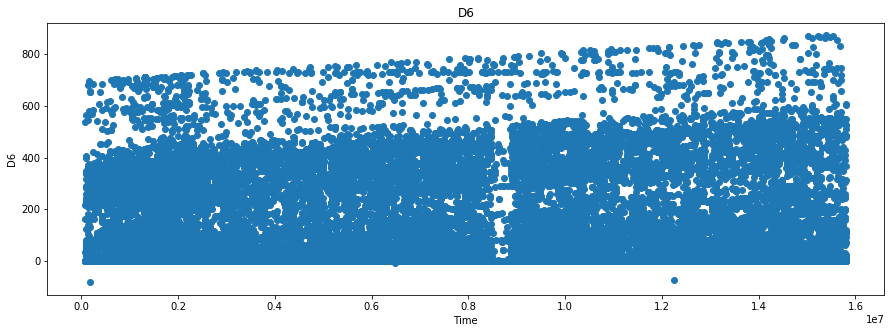

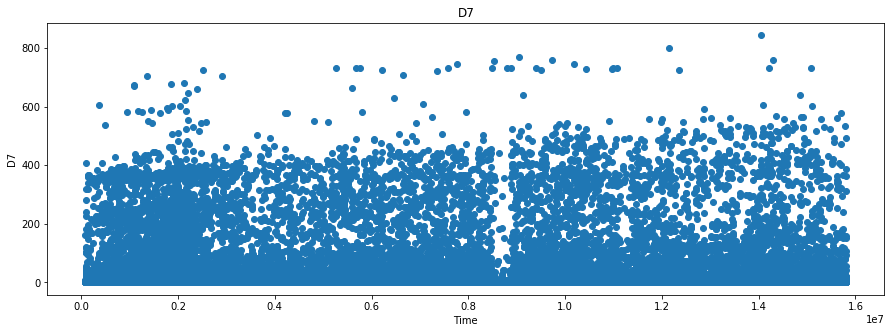

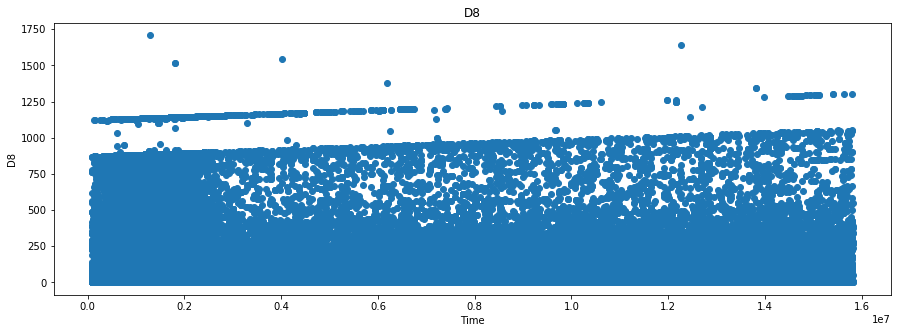

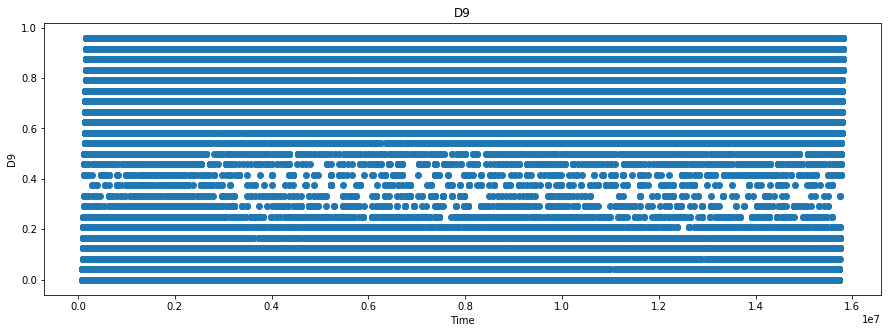

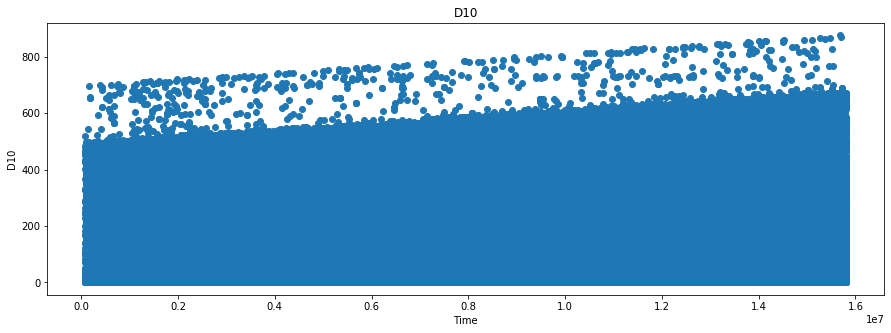

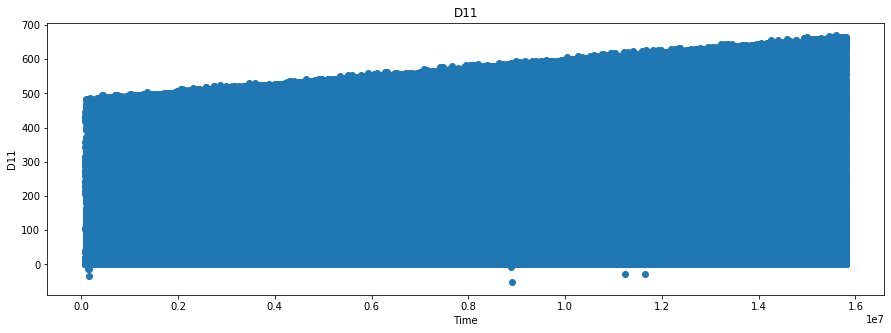

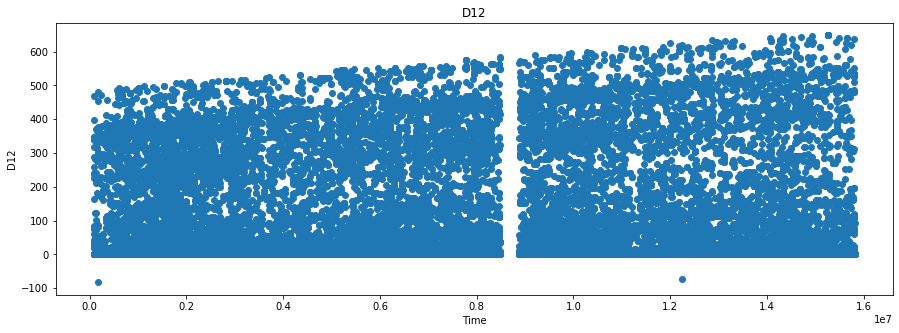

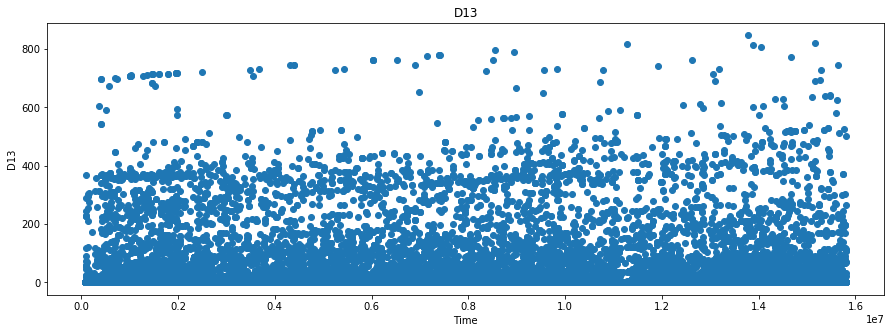

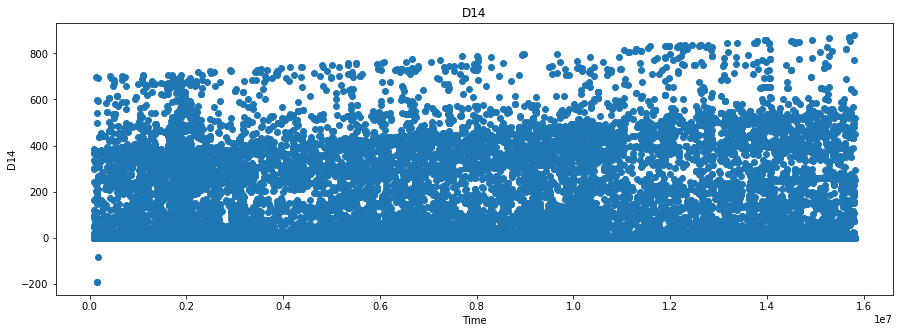

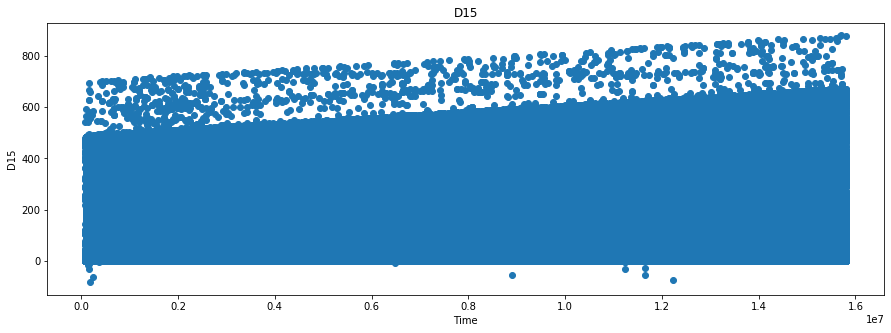

In [22]:
for D in ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',]:
    plt.figure(figsize=(15,5))
    plt.scatter(X.TransactionDT,X[D])
    plt.title(D)
    plt.xlabel('Time')
    plt.ylabel(D)
    plt.show()

可以比较明显看到有一些样本和时间之间存在很强的线性关系
TransactionDT是以秒为单位的，这个发现在discuss和notebook里都有，主要是发现(max(TransactionDT)-min(TransactionDT))/(24*50*50)
等于365+30,恰好是一年零一个月。。。所以确定了TransactionDT的基本单位是秒

In [25]:
(max(X_test.TransactionDT)-min(X.TransactionDT))/(24*60*60) 

394.9993518518518

这个要和标签的定义逻辑对应起来才能理解：



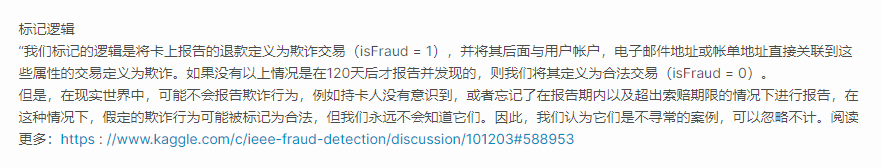

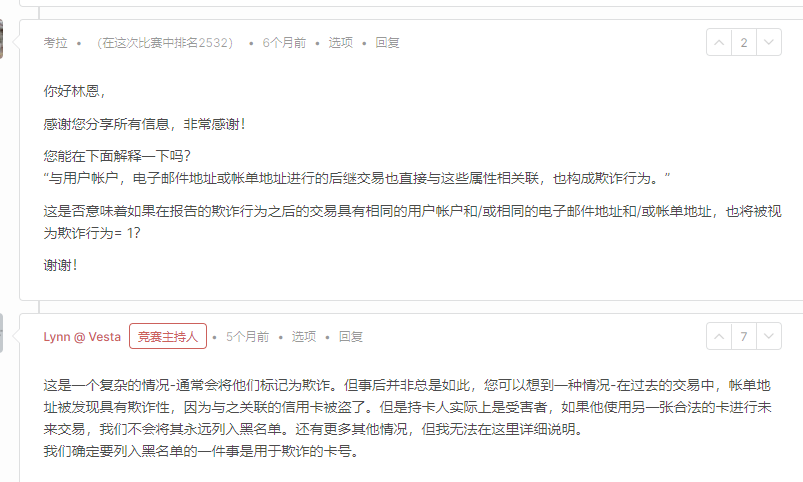

从上面的描述我们可以知道，这个数据集的样本并不是一条样本对应一个客户，而是一条样本对应一条交易记录，并且同一个客户可能有多条交易记录，可以看到
这里提到了，关联的用户账户（card1~card6）和电子邮件或账单地址（R_email_domain和p_email_domain）和这些都是用于确定同一起欺诈的也就是同一个用户；除此之外，每一个用户应该都有一个第一次开始交易的时间作为基准点然后才可以以此为基点计算时间增量。

In [ ]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    X['D'+str(i)] =  X['D'+str(i)] - X.TransactionDT/np.float32(24*60*60)

# None

## Feature Learning by Trees
GBDT derived feature + LR

In [6]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

gbdt = GradientBoostingClassifier(n_estimators=20)
one_hot = OneHotEncoder()

X_train = X_train[[ 'Pclass', 'Age', 'Fare', 'SibSp']].fillna(0)
X_test = X_test[[ 'Pclass', 'Age', 'Fare', 'SibSp']].fillna(0)

gbdt.fit(X_train, y_train)

X_leaf_index = gbdt.apply(X_train)[:, :, 0]  # apply return the node index on each tree 
print("sample's belonging node of each base tree \n'",X_leaf_index)
# fit one-hot encoder
one_hot.fit(X_leaf_index)   
X_one_hot = one_hot.transform(X_leaf_index)  


from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_one_hot,y_train)
y_pred = lr.predict_proba(
    one_hot.transform(gbdt.apply(X_test)[:, :, 0]))[:,1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred)
print("AUC for GBDT derived feature + LR：", roc_auc_score(y_test, y_pred))


sample's belonging node of each base tree 
' [[ 7.  7.  6. ...  4.  7.  4.]
 [ 7.  7.  6. ... 14.  7.  7.]
 [11. 11. 11. ...  4.  6. 11.]
 ...
 [10. 10. 10. ...  4.  6. 10.]
 [13. 14. 13. ...  4.  7. 13.]
 [ 7.  7.  6. ...  6.  7.  7.]]
AUC for GBDT derived feature + LR： 0.7746130952380953


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Feature Learning by Trees
RandomForest derived feature + LR

In [7]:
rf = RandomForestClassifier(n_estimators=20)
one_hot = OneHotEncoder()

X_train = X_train[[ 'Pclass', 'Age', 'Fare', 'SibSp']].fillna(0)
X_test = X_test[[ 'Pclass', 'Age', 'Fare', 'SibSp']].fillna(0)

rf.fit(X_train, y_train)

X_leaf_index = rf.apply(X_train)  # apply return the node index on each tree 
print("sample's belonging node of each base tree \n'",X_leaf_index)
# fit one-hot encoder
one_hot.fit(X_leaf_index)   
X_one_hot = one_hot.transform(X_leaf_index)  


lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_one_hot,y_train)
y_pred = lr.predict_proba(
    one_hot.transform(rf.apply(X_test)))[:,1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred)
print("AUC for RandomForest derived feature + LR：", roc_auc_score(y_test, y_pred))


sample's belonging node of each base tree 
' [[212  35  79 ... 146  60  46]
 [307 165 266 ... 136 132  44]
 [285 285 320 ... 301 294 300]
 ...
 [ 13 177 133 ... 186 169 117]
 [190 296 311 ... 282 289 297]
 [264 165 243 ... 152 110 314]]
AUC for RandomForest derived feature + LR： 0.759672619047619


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


##  Feature Learning by Trees
GBDT derived feature + Raw feature +LR

In [8]:
from scipy.sparse import hstack

X_train_ext = hstack([one_hot.transform(gbdt.apply(X_train)[:, :, 0]), X_train])
X_test_ext = hstack([one_hot.transform(gbdt.apply(X_test)[:, :, 0]), X_test])
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train_ext,y_train)
y_pred = lr.predict_proba(X_test_ext)[:,1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred)
print("AUC for GBDT derived feature + Raw feature +LR：", roc_auc_score(y_test, y_pred))


AUC for GBDT derived feature + Raw feature +LR： 0.7603571428571428


##  Feature Learning by Trees
RandomForest derived feature + Raw feature +LR

In [9]:
X_train_ext = hstack([one_hot.transform(rf.apply(X_train)), X_train])
X_test_ext = hstack([one_hot.transform(rf.apply(X_test)), X_test])
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train_ext,y_train)
y_pred = lr.predict_proba(X_test_ext)[:,1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred)
print("AUC for RandomForest derived feature + Raw feature + LR：", roc_auc_score(y_test, y_pred))


AUC for RandomForest derived feature + Raw feature + LR： 0.76


##  Feature Learning by Trees
Use only Raw Feature + LR

In [10]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train,y_train)
y_pred = lr.predict_proba(X_test)[:,1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred)
print("AUC for RandomForest derived feature + LR：", roc_auc_score(y_test, y_pred))


AUC for RandomForest derived feature + LR： 0.6988690476190476


## Feature Learning by Trees

Use only Raw Feature + GBDT

In [13]:
gbdt = GradientBoostingClassifier(n_estimators=20)

X_train = X_train[[ 'Pclass', 'Age', 'Fare', 'SibSp']].fillna(0)
X_test = X_test[[ 'Pclass', 'Age', 'Fare', 'SibSp']].fillna(0)

gbdt.fit(X_train, y_train)
y_pred = gbdt.predict_proba(X_test)[:,1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred)
print("AUC for Raw feature + GBDT：", roc_auc_score(y_test, y_pred))


AUC for Raw feature + GBDT： 0.7613988095238096


## Feature Learning by Trees

Use only Raw Feature + RF


In [16]:
rf = RandomForestClassifier(n_estimators=20)

X_train = X_train[[ 'Pclass', 'Age', 'Fare', 'SibSp']].fillna(0)
X_test = X_test[[ 'Pclass', 'Age', 'Fare', 'SibSp']].fillna(0)

rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:,1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred)
print("AUC for Raw feature + RF：", roc_auc_score(y_test, y_pred))

AUC for Raw feature + RF： 0.7235119047619047


#### Without tuning, we can see GBDT derived feature + LR get the best result